Connected to base (Python 3.11.7)

In [ ]:
import pandas as pd
import altair as alt
import time

import warnings 
warnings.filterwarnings('ignore')
alt.renderers.enable("png")

from datetime import datetime

import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://oig.hhs.gov/fraud/enforcement/'
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

titles = []
dates = []
links = []
categories = []

enforcement_items = soup.find_all('li', class_='usa-card card--list pep-card--minimal mobile:grid-col-12')

for item in enforcement_items:
    title_tag = item.find('h2', class_='usa-card__heading')
    title = title_tag.get_text(strip=True)
    titles.append(title)

    date_tag = item.find('span', class_='text-base-dark padding-right-105')
    date = date_tag.get_text(strip=True) 
    dates.append(date)

    category_tag = item.find('li', class_='display-inline-block usa-tag text-no-lowercase text-base-darkest bg-base-lightest margin-right-1')
    category = category_tag.get_text(strip=True)
    categories.append(category)

    link_tag = title_tag.find('a', href=True) 
    link = link_tag['href'] if link_tag else 'N/A'
    if not link.startswith('http'):
        full_link = f'https://oig.hhs.gov{link}'
    else:
        full_link = link
    links.append(full_link)

df = pd.DataFrame({
    'Title': titles,
    'Date': dates,
    'Category': categories,
    'Link': links
})

print(df.head())


import time

agencies = []

for full_link in links:
    action_response = requests.get(full_link)
    action_response.raise_for_status()
    action_soup = BeautifulSoup(action_response.text, 'html.parser')

    agency_tag = action_soup.find('span', string='Agency:')
    if agency_tag:
        agency = agency_tag.find_parent('li').get_text(
            strip=True).replace('Agency:', '').strip()
    else:
        agency = 'N/A'

    agencies.append(agency)

    time.sleep(1)

df = pd.DataFrame({
    'Title': titles,
    'Date': dates,
    'Category': categories,
    'Link': links,
    'Agency': agencies
})

print(df.head())



import concurrent.futures
from datetime import datetime

def scrape_enforcement_actions(start_month, start_year, end_page=480):
    if start_year < 2013:
        print("Year must be >= 2013. Please provide a valid year.")
        return

    titles, dates, links, categories, agencies = [], [], [], [], []

    base_url = 'https://oig.hhs.gov/fraud/enforcement/'
    page_number = 1

    while page_number <= end_page:
        url = f"{base_url}?page={page_number}"
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        enforcement_items = soup.find_all('li', class_='usa-card card--list pep-card--minimal mobile:grid-col-12')

        if not enforcement_items:
            break

        valid_data_found = False

        for item in enforcement_items:
            try:
                title = item.find('h2', class_='usa-card__heading').get_text(strip=True)
                date = item.find('span', class_='text-base-dark padding-right-105').get_text(strip=True)
                date_obj = datetime.strptime(date, "%B %d, %Y")

                # Stop if the date is earlier than start date
                if date_obj < datetime(start_year, start_month, 1):
                    continue

                valid_data_found = True
                category = item.find('ul', class_='display-inline add-list-reset').get_text(strip=True) if item.find('ul', class_='display-inline add-list-reset') else 'N/A'
                link = item.find('a', href=True)['href']
                full_link = f'https://oig.hhs.gov{link}'
            except AttributeError:
                continue

            titles.append(title)
            dates.append(date)
            categories.append(category)
            links.append(full_link)

        time.sleep(1)

        if not valid_data_found:
            break

        page_number += 1

    def get_agency_info(link):
        try:
            action_response = requests.get(link)
            action_response.raise_for_status()
            action_soup = BeautifulSoup(action_response.text, 'html.parser')

            agency_tag = action_soup.find('span', string='Agency:')
            agency = agency_tag.find_parent('li').get_text(strip=True).replace('Agency:', '').strip() if agency_tag else 'N/A'
        except (requests.exceptions.RequestException, AttributeError):
            agency = 'N/A'
        return agency

    if links:
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            agencies = list(executor.map(get_agency_info, links))

        df = pd.DataFrame({
            'Title': titles,
            'Date': dates,
            'Category': categories,
            'Link': links,
            'Agency': agencies
        })

        filename = f"enforcement_actions_{start_year}_{start_month}.csv"
        df.to_csv(filename, index=False)

        print(f"Scraping complete. Data saved to {filename}.")

scrape_enforcement_actions(1, 2023)


scrape_enforcement_actions(1, 2021)

filename = "enforcement_actions_2021_1.csv"
df = pd.read_csv(filename)

total_actions = len(df)
print(f"Total number of enforcement actions scraped: {total_actions}")

earliest_action = df.iloc[-1]
print(f"Earliest enforcement action: Date - {earliest_action['Date']}, Title - {earliest_action['Title']}, Link - {earliest_action['Link']}")


import altair as alt

file_path = "/Users/cynthia/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])

data['YearMonth'] = data['Date'].dt.to_period('M')

monthly_counts = data.groupby('YearMonth').size().reset_index(name='Count')

monthly_counts['YearMonth'] = monthly_counts['YearMonth'].astype(str)

chart = alt.Chart(monthly_counts).mark_line(point=True).encode(
    alt.X('YearMonth:T', title='Year-Month', axis=alt.Axis(labelAngle=-45)),
    alt.Y('Count:Q', title='Number of Actions'),
    tooltip=['YearMonth', 'Count']
).properties(
    title='Number of Enforcement Actions Over Time (Since January 2021)',
    width=800,
    height=400
)

chart.show()



file_path = "/Users/cynthia/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.dropna(subset=['Date'])
data['YearMonth'] = data['Date'].dt.to_period('M')

data['Category'] = data['Category'].apply(lambda x: 'Criminal and Civil Actions' if 'Criminal and Civil Actions' in x else 'State Enforcement Agencies')

def assign_subcategory(title):
    title_lower = title.lower()
    if 'health' in title_lower or 'medicare' in title_lower or 'medicaid' in title_lower:
        return 'Health Care Fraud'
    elif 'financial' in title_lower or 'bank' in title_lower or 'money laundering' in title_lower:
        return 'Financial Fraud'
    elif 'drug' in title_lower or 'narcotic' in title_lower:
        return 'Drug Enforcement'
    elif 'bribe' in title_lower or 'corrupt' in title_lower or 'kickback' in title_lower:
        return 'Bribery/Corruption'
    else:
        return 'Other'

data['SubCategory'] = data.apply(lambda row: assign_subcategory(row['Title']) if row['Category'] == 'Criminal and Civil Actions' else None, axis=1)

main_category_counts = data.groupby(['YearMonth', 'Category']).size().reset_index(name='Count')
main_category_counts['YearMonth'] = main_category_counts['YearMonth'].astype(str)

main_chart = alt.Chart(main_category_counts).mark_line(point=True).encode(
    alt.X('YearMonth:T', title='Year-Month', axis=alt.Axis(labelAngle=-45)),
    alt.Y('Count:Q', title='Number of Actions'),
    color='Category:N',
    tooltip=['YearMonth', 'Category', 'Count']
).properties(
    title='Number of Enforcement Actions: Criminal and Civil Actions vs. State Enforcement Agencies',
    width=800,
    height=400
).interactive()

main_chart.show()


subcategory_data = data[data['Category'] == 'Criminal and Civil Actions']
subcategory_counts = subcategory_data.groupby(['YearMonth', 'SubCategory']).size().reset_index(name='Count')
subcategory_counts['YearMonth'] = subcategory_counts['YearMonth'].astype(str)

subcategory_chart = alt.Chart(subcategory_counts).mark_line(point=True).encode(
    alt.X('YearMonth:T', title='Year-Month', axis=alt.Axis(labelAngle=-45)),
    alt.Y('Count:Q', title='Number of Actions'),
    color='SubCategory:N',
    tooltip=['YearMonth', 'SubCategory', 'Count']
).properties(
    title='Number of Enforcement Actions by SubCategory (Criminal and Civil Actions)',
    width=800,
    height=400
).interactive()

subcategory_chart.show()


import matplotlib.pyplot as plt

state_data = data[data['Agency'].str.contains(
    'State of', na=False, case=False)]


def extract_state_name(agency):
    parts = agency.split()
    if "State" in parts and "of" in parts:
        index = parts.index("of") + 1
        if index < len(parts):
            return parts[index]
    return None


state_data['State'] = state_data['Agency'].apply(extract_state_name)

state_data = state_data.dropna(subset=['State'])

state_data['State'] = state_data['State'].str.strip().str.title()

state_counts = state_data['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

gdf_states = gpd.read_file(
    "/Users/cynthia/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

gdf_states['NAME'] = gdf_states['NAME'].str.strip().str.title()

gdf_merged = gdf_states.merge(
    state_counts, how='left', left_on='NAME', right_on='State')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6,
                             })

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)

plt.title('Number of State-Level Enforcement Actions by State (Since January 2021)', fontsize=20)
plt.axis('off')

plt.show()

                                               Title              Date  \
0  Pharmacist and Brother Convicted of $15M Medic...  November 8, 2024   
1  Boise Nurse Practitioner Sentenced To 48 Month...  November 7, 2024   
2  Former Traveling Nurse Pleads Guilty To Tamper...  November 7, 2024   
3  Former Arlington Resident Sentenced To Prison ...  November 7, 2024   
4  Paroled Felon Sentenced To Six Years For Fraud...  November 7, 2024   

                     Category  \
0  Criminal and Civil Actions   
1  Criminal and Civil Actions   
2  Criminal and Civil Actions   
3  Criminal and Civil Actions   
4  Criminal and Civil Actions   

                                                Link  
0  https://oig.hhs.gov/fraud/enforcement/pharmaci...  
1  https://oig.hhs.gov/fraud/enforcement/boise-nu...  
2  https://oig.hhs.gov/fraud/enforcement/former-t...  
3  https://oig.hhs.gov/fraud/enforcement/former-a...  
4  https://oig.hhs.gov/fraud/enforcement/paroled-...  
                          

FileNotFoundError: [Errno 2] No such file or directory: '/Users/cynthia/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2023_1_to_present.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U.S. Attorney\'s Office, ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/path/to/your/us_attorney_districts_shapefile.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'enforcement_actions_2023_1_to_present.csv'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2023_1_to_present.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U.S. Attorney\'s Office, ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/path/to/your/us_attorney_districts_shapefile.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2023_1_to_present.csv'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2023_1_to_present.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U.S. Attorney\'s Office, ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/us_attorney_districts_shapefile.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'enforcement_actions_2023_1_to_present.csv'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U.S. Attorney\'s Office, ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/us_attorney_districts_shapefile.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

DataSourceError: /Users/hahei/Desktop/problem-set-5-xy-wz/us_attorney_districts_shapefile.shp: No such file or directory

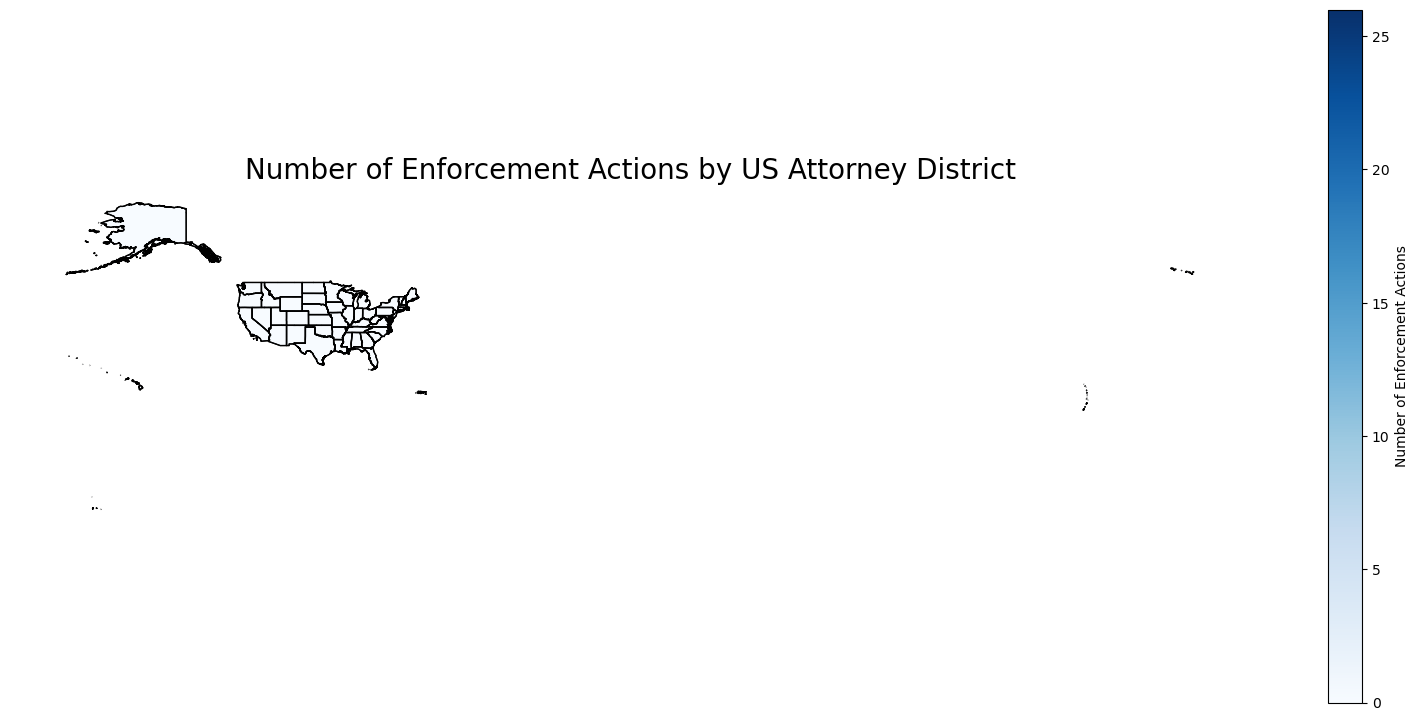

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U.S. Attorney\'s Office, ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

state_data = data[data['Agency'].str.contains(
    'State of', na=False, case=False)]


def extract_state_name(agency):
    parts = agency.split()
    if "State" in parts and "of" in parts:
        index = parts.index("of") + 1
        if index < len(parts):
            return parts[index]
    return None


state_data['State'] = state_data['Agency'].apply(extract_state_name)

state_data = state_data.dropna(subset=['State'])

state_data['State'] = state_data['State'].str.strip().str.title()

state_counts = state_data['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

gdf_states = gpd.read_file(
    "/Users/cynthia/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

gdf_states['NAME'] = gdf_states['NAME'].str.strip().str.title()

gdf_merged = gdf_states.merge(
    state_counts, how='left', left_on='NAME', right_on='State')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6,
                             })

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)

plt.title('Number of State-Level Enforcement Actions by State (Since January 2021)', fontsize=20)
plt.axis('off')

plt.show()

DataSourceError: /Users/cynthia/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp: No such file or directory

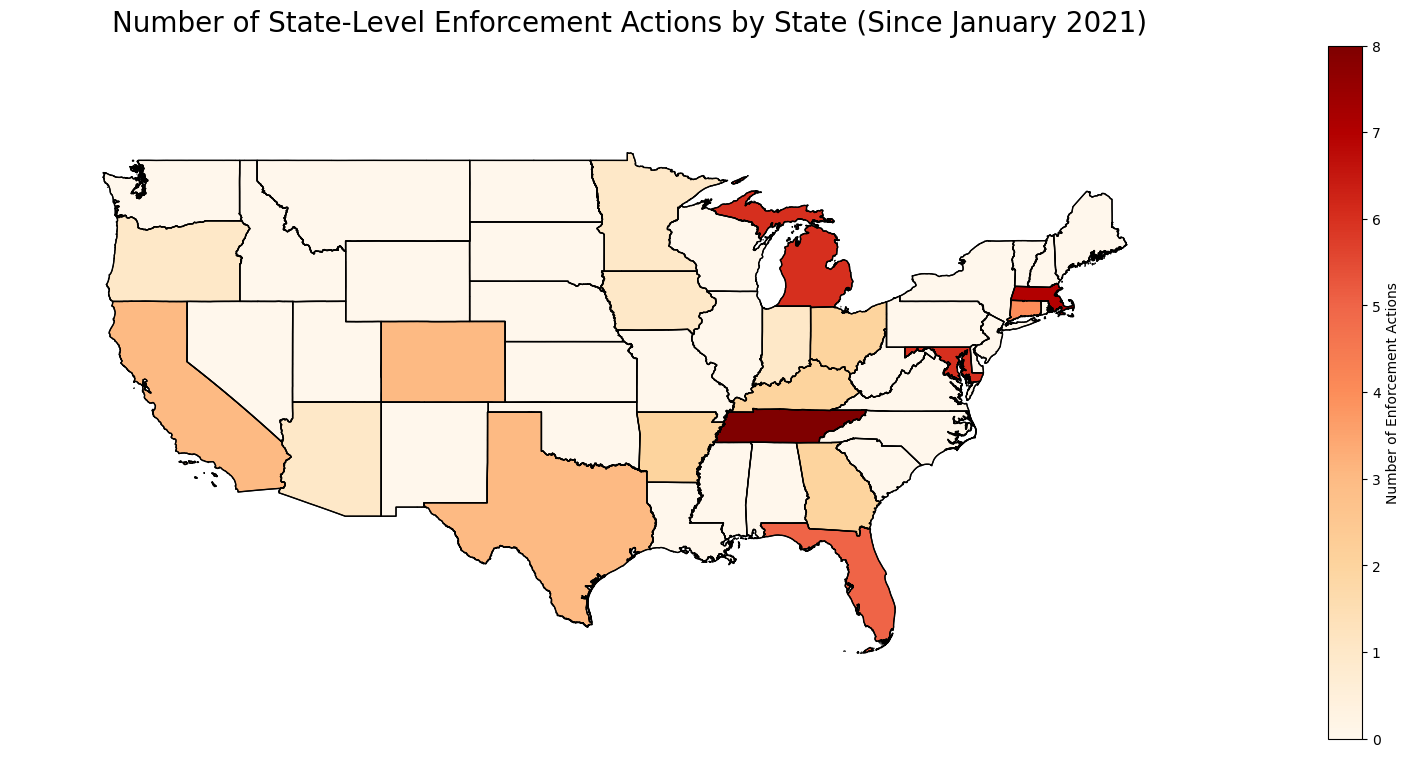

In [ ]:
import matplotlib.pyplot as plt

state_data = data[data['Agency'].str.contains(
    'State of', na=False, case=False)]


def extract_state_name(agency):
    parts = agency.split()
    if "State" in parts and "of" in parts:
        index = parts.index("of") + 1
        if index < len(parts):
            return parts[index]
    return None


state_data['State'] = state_data['Agency'].apply(extract_state_name)

state_data = state_data.dropna(subset=['State'])

state_data['State'] = state_data['State'].str.strip().str.title()

state_counts = state_data['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

gdf_states = gpd.read_file(
    "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

gdf_states['NAME'] = gdf_states['NAME'].str.strip().str.title()

gdf_merged = gdf_states.merge(
    state_counts, how='left', left_on='NAME', right_on='State')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6,
                             })

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)

plt.title('Number of State-Level Enforcement Actions by State (Since January 2021)', fontsize=20)
plt.axis('off')

plt.show()

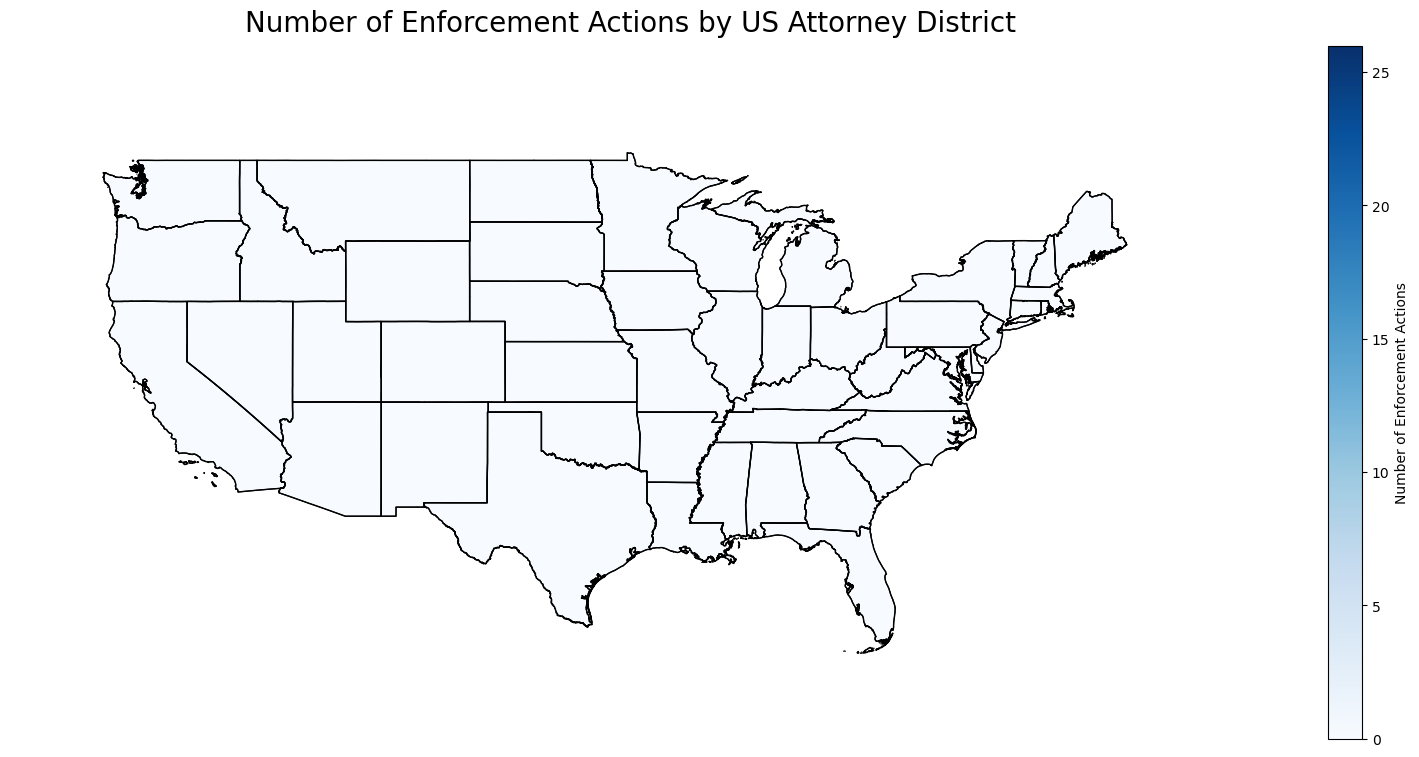

In [ ]:
# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U.S. Attorney\'s Office, ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})


ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)

plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

Unique district names in data before merging:
['Texas' 'Pennsylvania' 'New York' 'Massachusetts' 'Florida' 'California'
 'New Jersey' 'Connecticut' 'North Carolina' 'Missouri' 'Michigan'
 'Georgia' 'Maryland' 'Illinois' 'Virginia' 'Tennessee' 'Washington'
 'Louisiana' 'Ohio' 'Kentucky' 'Columbia' 'Iowa' 'South Carolina'
 'Alabama' 'Rhode Island' 'Oklahoma' 'Montana' 'Wisconsin' 'West Virginia'
 'Arkansas' 'Idaho' 'South Dakota' 'Indiana' 'Minnesota' 'Mississippi'
 'Puerto Rico' 'New Hampshire' 'Colorado' 'Arizona' 'Kansas' 'Delaware'
 'Oregon' 'Utah' 'Maine' 'Vermont' 'Wyoming' 'Alaska' 'North Dakota'
 'Kentucky and U' 'Florida and U' 'Texas and U' 'Nevada' 'Idaho Boise'
 'Nebraska' 'Columbia Inspector General' 'Hawaii' 'Pennsylvani']
Unique district names in shapefile before merging:
['Mississippi' 'North Carolina' 'Oklahoma' 'Virginia' 'West Virginia'
 'Louisiana' 'Michigan' 'Massachusetts' 'Idaho' 'Florida' 'Nebraska'
 'Washington' 'New Mexico' 'Puerto Rico' 'South Dakota' 'Texas'
 

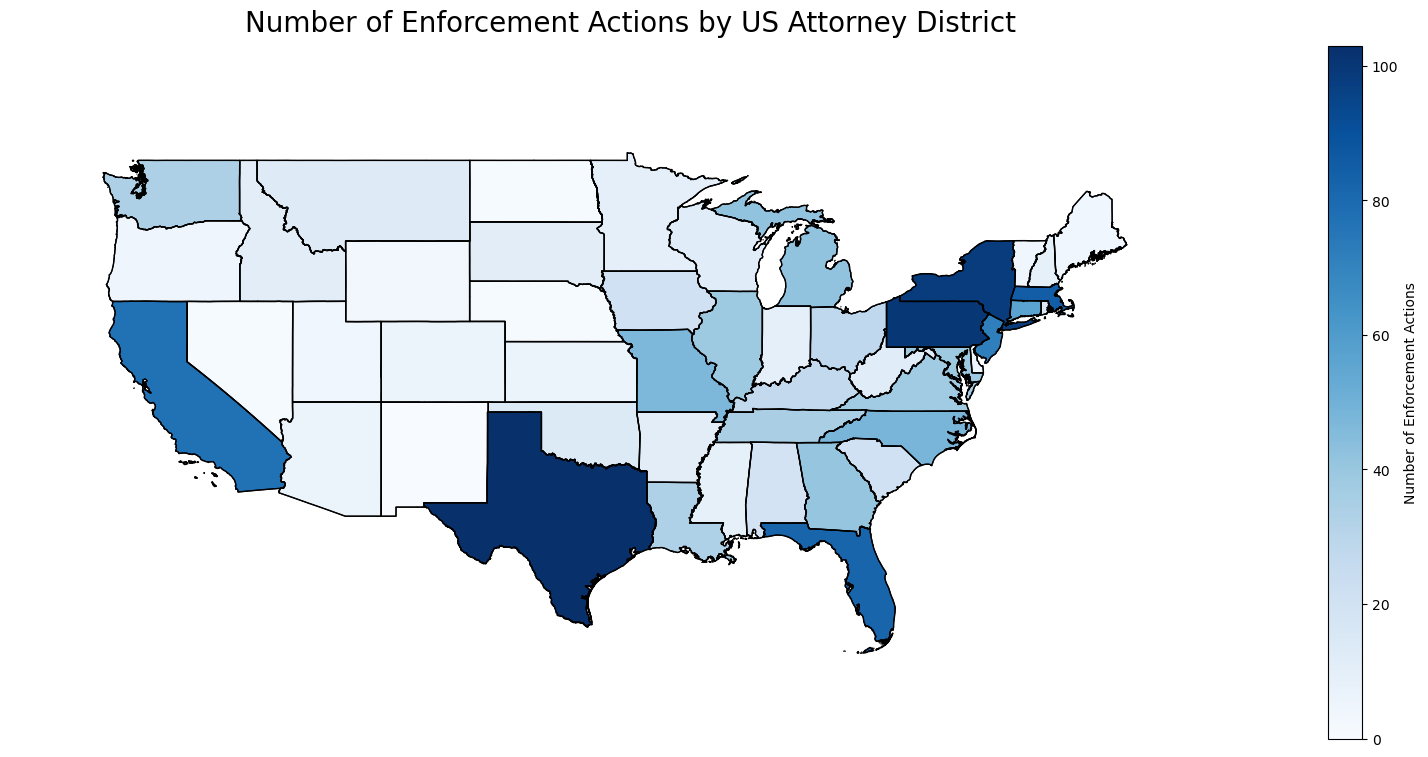

In [ ]:
# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Standardize district names in both datasets to ensure matching
print("Unique district names in data before merging:")
print(district_counts['District'].unique())
print("Unique district names in shapefile before merging:")
print(gdf_districts['District'].unique())

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

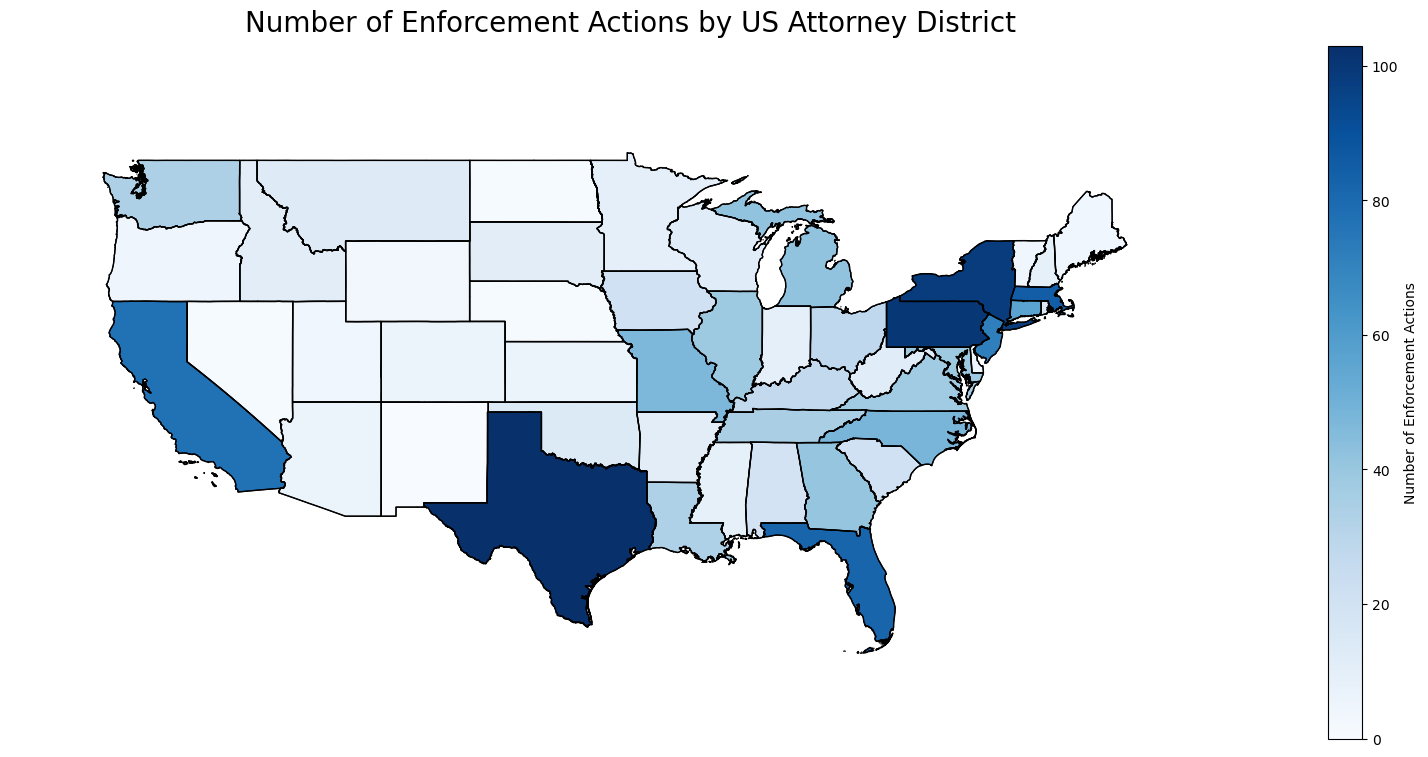

In [ ]:
# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Standardize district names in both datasets to ensure matching


# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

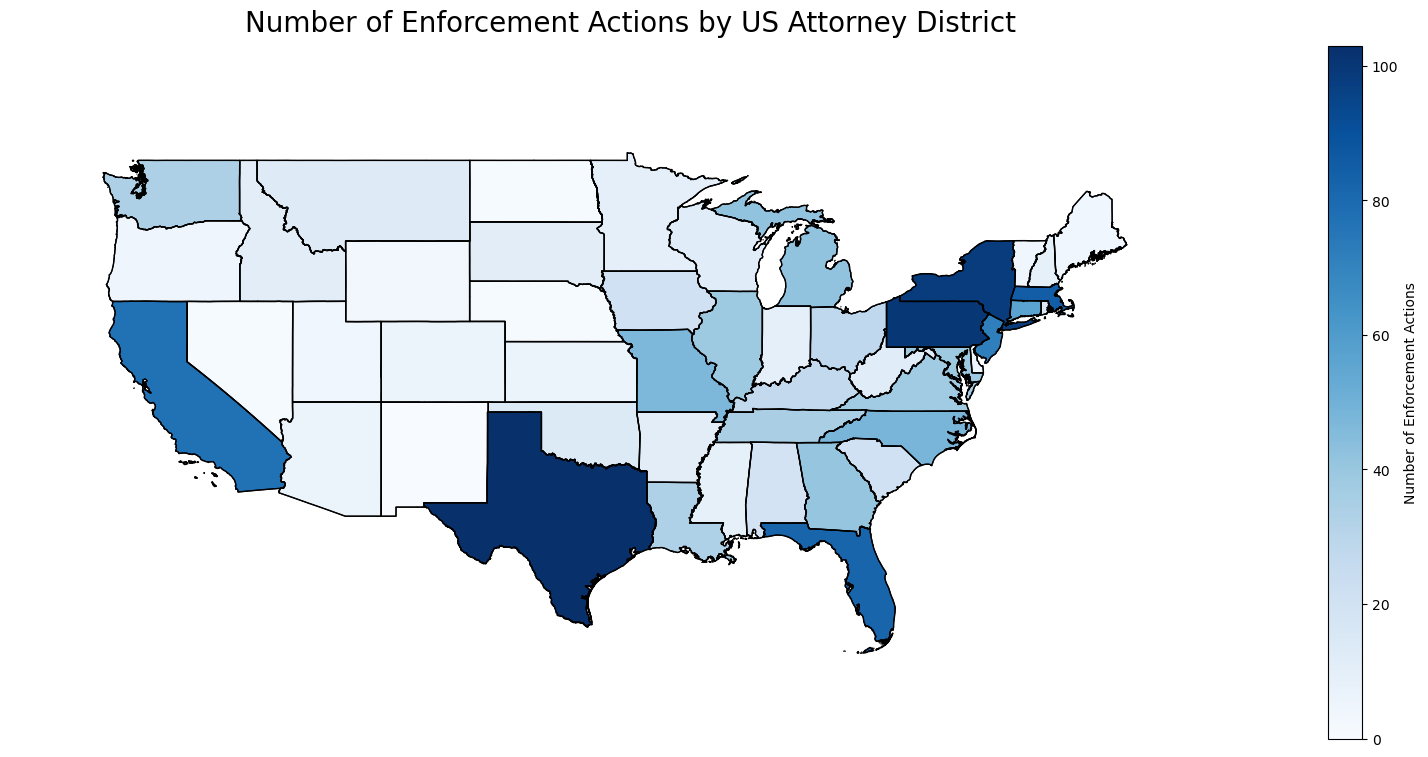

In [ ]:
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

data["District"] = data["Agency"].apply(
    lambda x: (
        re.search(r"District of [A-Za-z ]+", x).group(0)
        if pd.notnull(x) and "District" in x
        else None
    )
)

district_data = data.dropna(subset=["District"]).copy()

district_data["District"] = (
    district_data["District"]
    .str.replace("U\.S\. Attorney's Office, ", "")
    .str.replace("District of ", "")
    .str.strip()
)

district_counts = district_data["District"].value_counts().reset_index()
district_counts.columns = ["District", "Count"]

shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

gdf_districts["District"] = gdf_districts["NAME"].str.strip()


gdf_merged = gdf_districts.merge(
    district_counts, how="left", left_on="District", right_on="District"
)
gdf_merged["Count"] = gdf_merged["Count"].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
gdf_merged.plot(
    column="Count",
    cmap="Blues",
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Number of Enforcement Actions", "shrink": 0.6},
)

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title("Number of Enforcement Actions by US Attorney District", fontsize=20)
plt.axis("off")
plt.show()

In [ ]:
# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='ZCTA5CE10', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

DataSourceError: /Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta500k.shp: No such file or directory

In [ ]:
# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='ZCTA5CE10', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

DataSourceError: /Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta500k.shp: No such file or directory

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='ZCTA5CE10', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

DataSourceError: /Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta500k.shp: No such file or directory

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/cb_2018_us_zcta500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='ZCTA5CE10', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

DataSourceError: /Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/cb_2018_us_zcta500k.shp: No such file or directory

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='ZCTA5CE10', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1-Data.csv'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='ZCTA5CE10', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1-Data.csv'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='ZCTA5CE10', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

KeyError: 'ZCTA5CE10'

In [ ]:
# 查看 ZIP shapefile 的列名
print(gdf_zip.columns)


Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


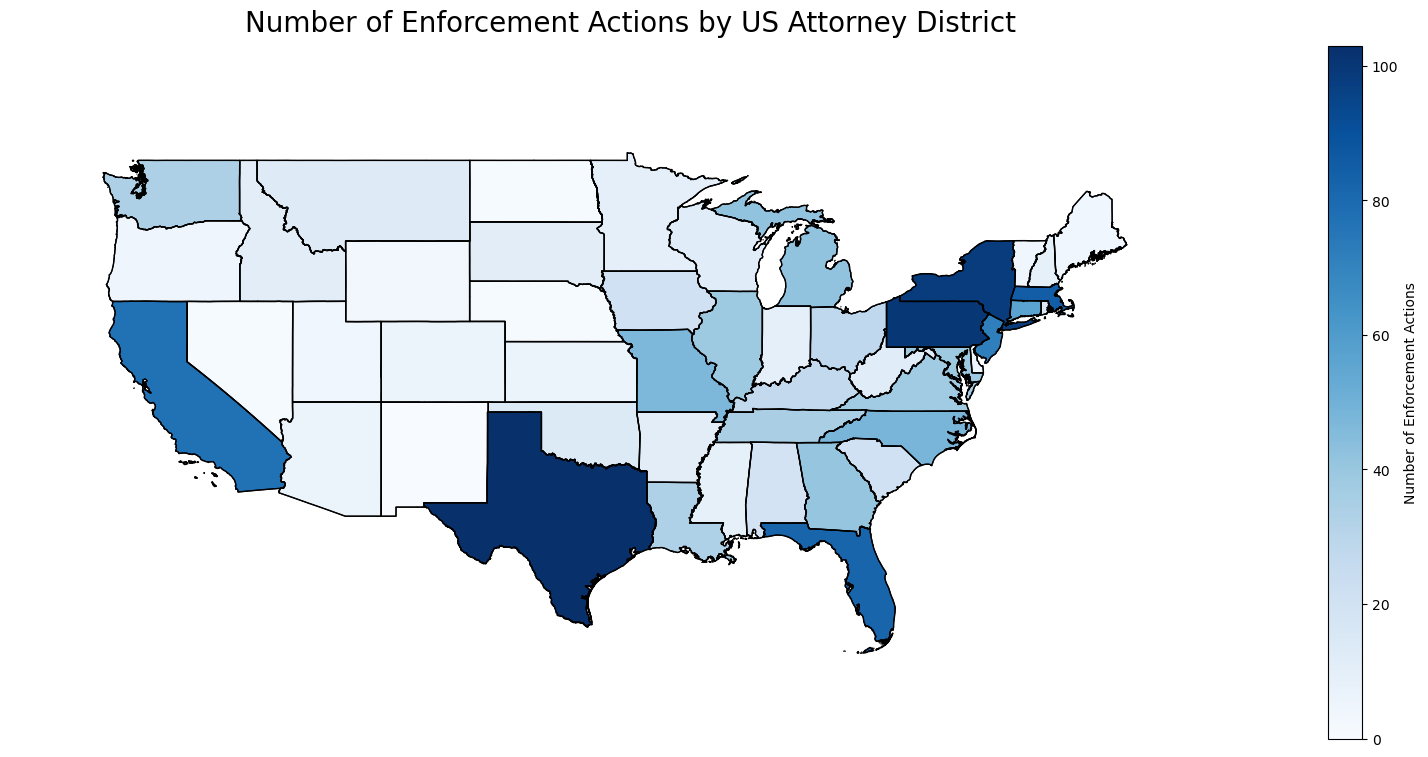

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title('Number of Enforcement Actions by US Attorney District', fontsize=20)
plt.axis('off')
plt.show()

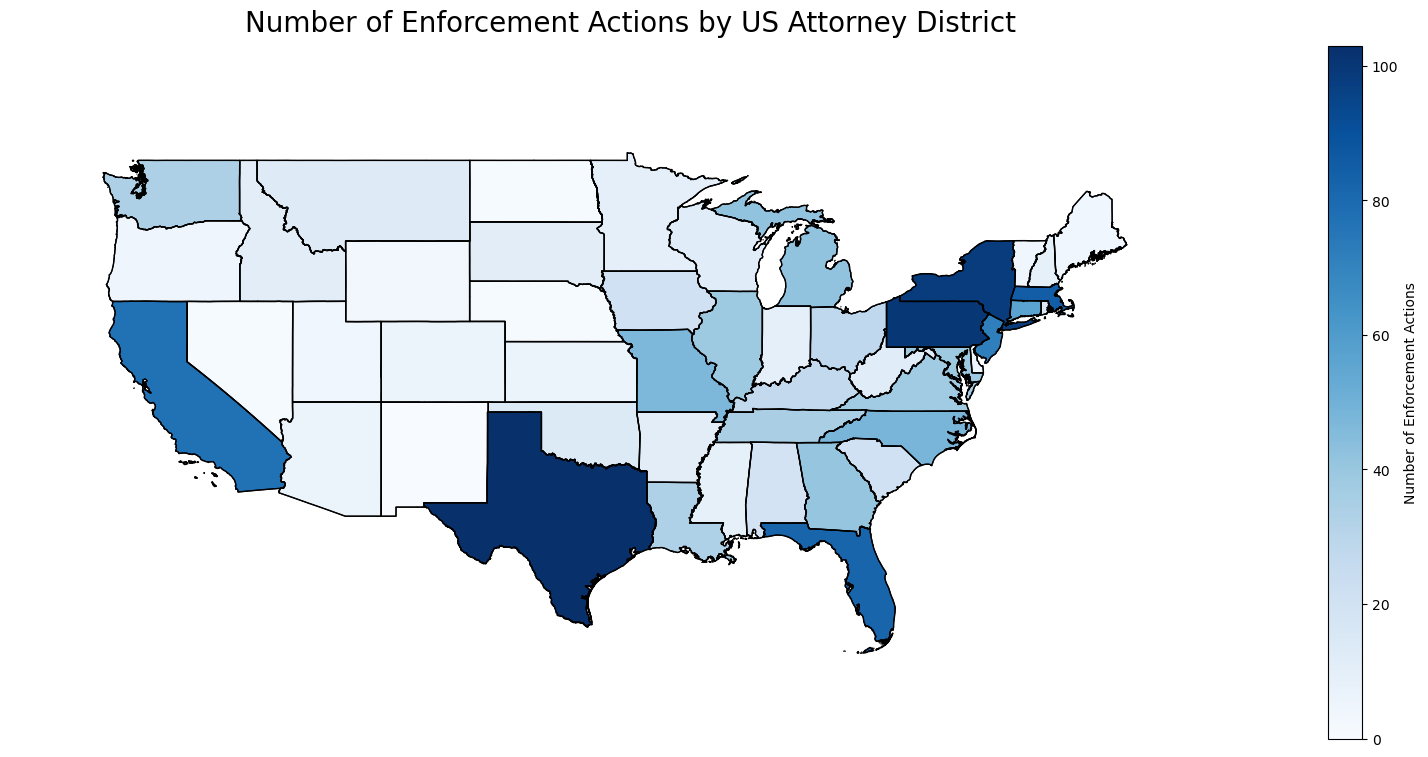

In [ ]:
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

data["District"] = data["Agency"].apply(
    lambda x: (
        re.search(r"District of [A-Za-z ]+", x).group(0)
        if pd.notnull(x) and "District" in x
        else None
    )
)

district_data = data.dropna(subset=["District"]).copy()

district_data["District"] = (
    district_data["District"]
    .str.replace("U\.S\. Attorney's Office, ", "")
    .str.replace("District of ", "")
    .str.strip()
)

district_counts = district_data["District"].value_counts().reset_index()
district_counts.columns = ["District", "Count"]

shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

gdf_districts["District"] = gdf_districts["NAME"].str.strip()


gdf_merged = gdf_districts.merge(
    district_counts, how="left", left_on="District", right_on="District"
)
gdf_merged["Count"] = gdf_merged["Count"].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
gdf_merged.plot(
    column="Count",
    cmap="Blues",
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Number of Enforcement Actions", "shrink": 0.6},
)

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title("Number of Enforcement Actions by US Attorney District", fontsize=20)
plt.axis("off")
plt.show()

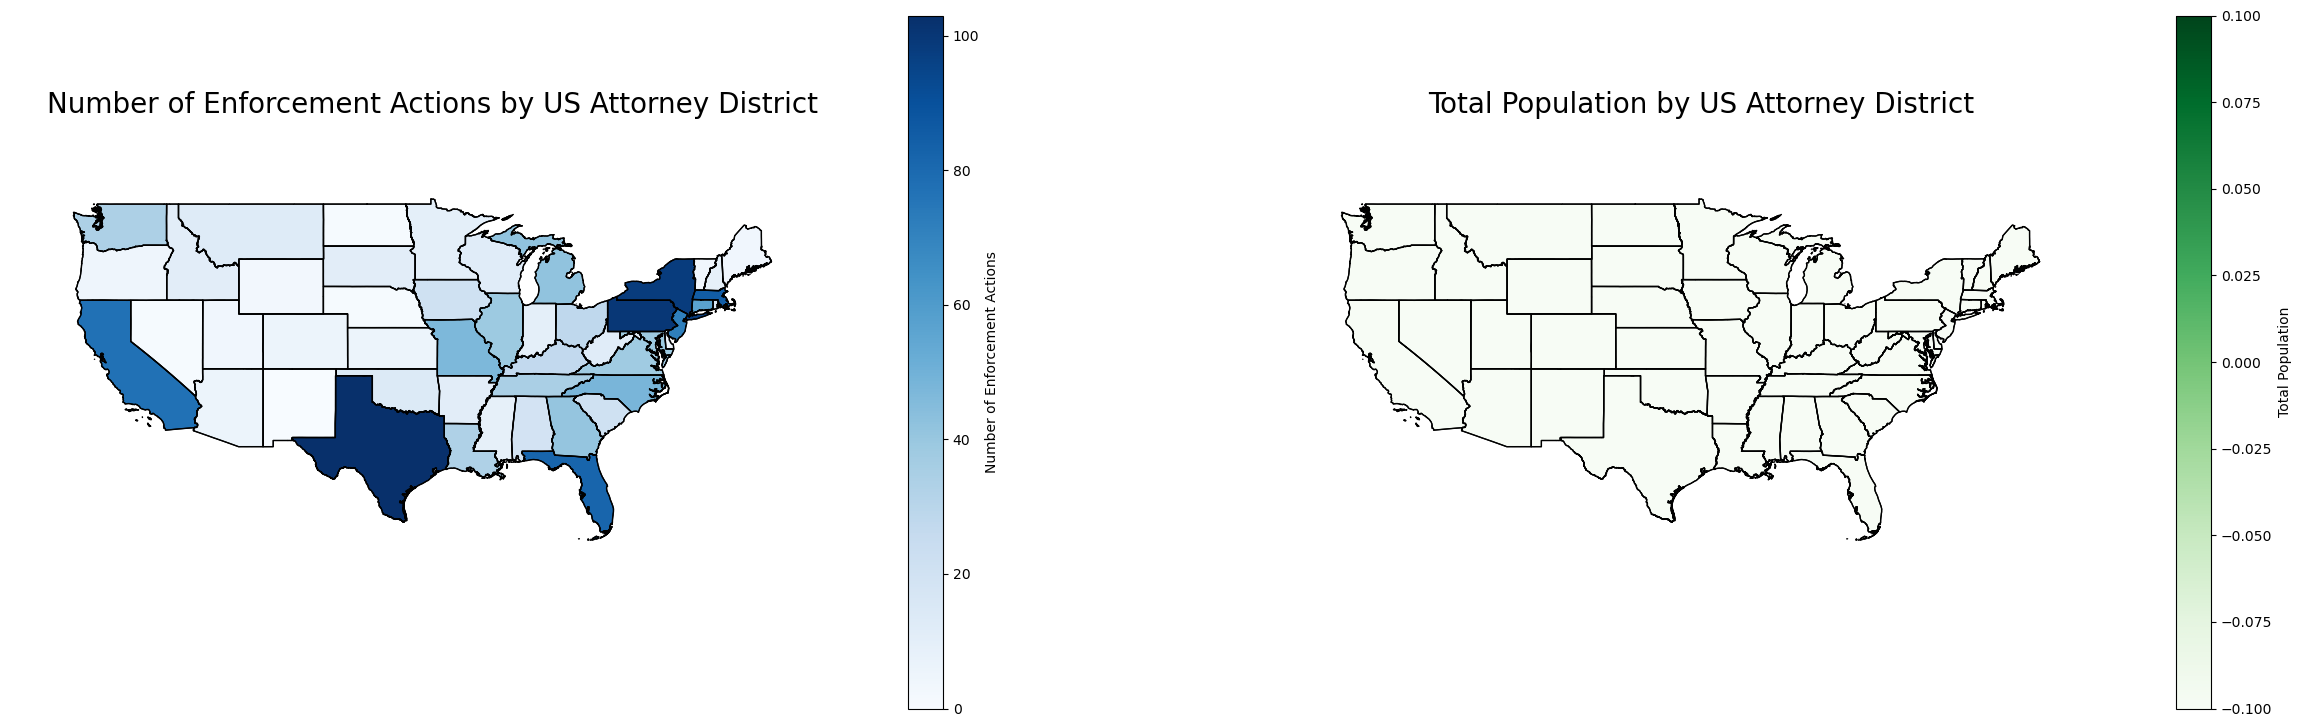

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district and population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Plot the number of enforcement actions
gdf_merged.boundary.plot(ax=ax1, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)
ax1.set_title('Number of Enforcement Actions by US Attorney District', fontsize=20)
ax1.axis('off')

# Plot the total population
gdf_merged.boundary.plot(ax=ax2, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)
ax2.set_title('Total Population by US Attorney District', fontsize=20)
ax2.axis('off')

plt.show()

In [ ]:
print("Districts GeoDataFrame after spatial join:")
print(gdf_districts[['District', 'Total_Population']].head())

print("Aggregated Population Data:")
print(district_population.head())


Districts GeoDataFrame after spatial join:
         District  Total_Population
0     Mississippi                 0
1  North Carolina                 0
2        Oklahoma                 0
3        Virginia                 0
4   West Virginia                 0
Aggregated Population Data:
         District Total_Population
0         Alabama                0
1          Alaska                0
2  American Samoa                0
3         Arizona                0
4        Arkansas                0


Number of records after spatial join: 274


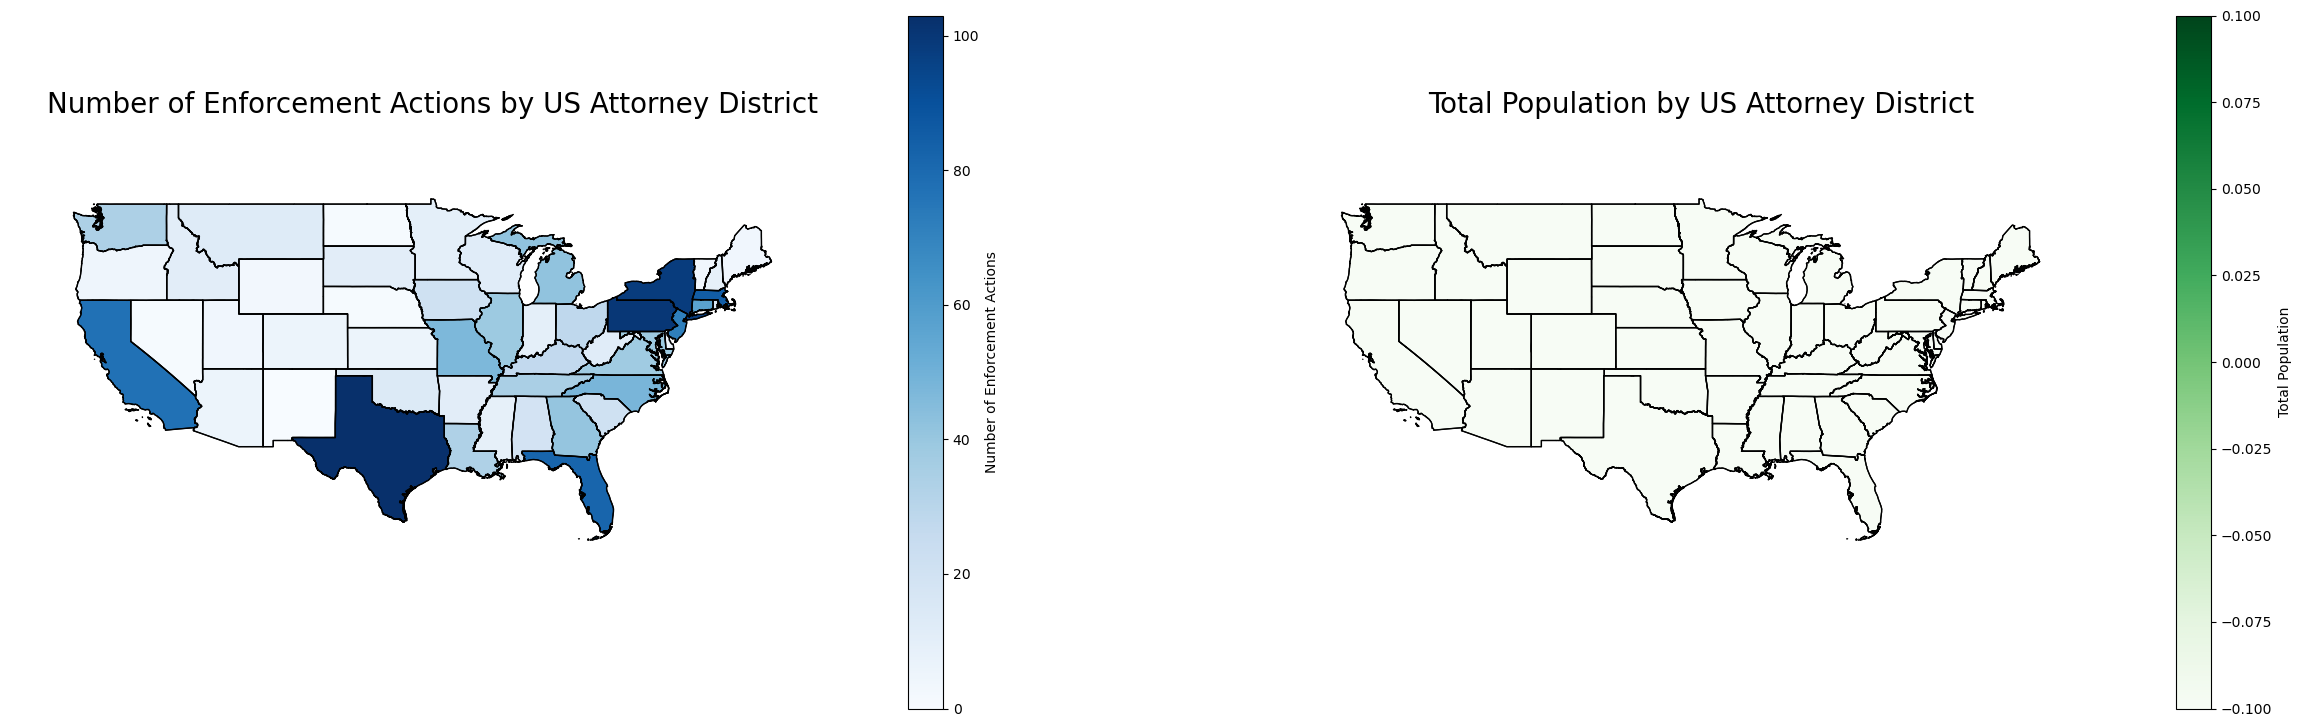

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Ensure both GeoDataFrames have the same CRS
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district and population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Plot the number of enforcement actions
gdf_merged.boundary.plot(ax=ax1, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)
ax1.set_title('Number of Enforcement Actions by US Attorney District', fontsize=20)
ax1.axis('off')

# Plot the total population
gdf_merged.boundary.plot(ax=ax2, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)
ax2.set_title('Total Population by US Attorney District', fontsize=20)
ax2.axis('off')

plt.show()

Number of records after spatial join: 274
Sample of spatial join result:
  STATEFP_left STATENS_left AFFGEOID_left GEOID_left STUSPS_left    NAME_left  \
0           28     01779790   0400000US28         28          MS  Mississippi   
0           28     01779790   0400000US28         28          MS  Mississippi   
0           28     01779790   0400000US28         28          MS  Mississippi   
0           28     01779790   0400000US28         28          MS  Mississippi   
0           28     01779790   0400000US28         28          MS  Mississippi   

  LSAD_left    ALAND_left  AWATER_left  \
0        00  121533519481   3926919758   
0        00  121533519481   3926919758   
0        00  121533519481   3926919758   
0        00  121533519481   3926919758   
0        00  121533519481   3926919758   

                                            geometry  ... STATEFP_right  \
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  ...            22   
0  MULTIPOLYGON (((-88.50297 30.21523

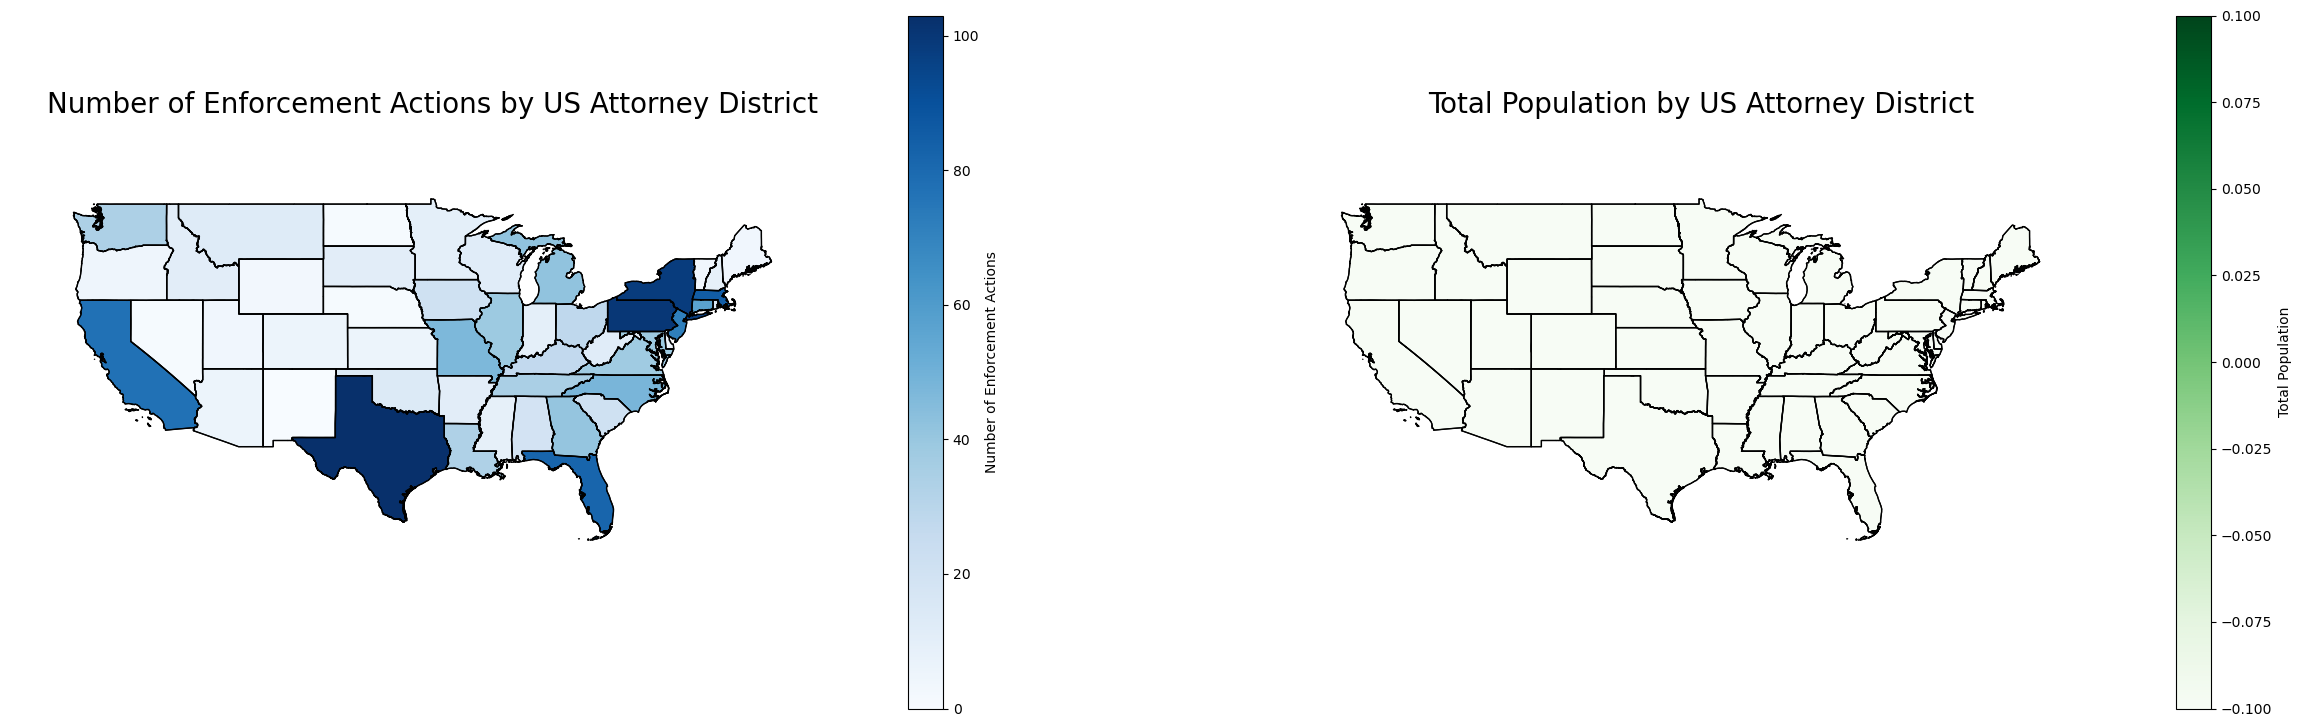

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Ensure both GeoDataFrames have the same CRS
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district and population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Plot the number of enforcement actions
gdf_merged.boundary.plot(ax=ax1, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)
ax1.set_title('Number of Enforcement Actions by US Attorney District', fontsize=20)
ax1.axis('off')

# Plot the total population
gdf_merged.boundary.plot(ax=ax2, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)
ax2.set_title('Total Population by US Attorney District', fontsize=20)
ax2.axis('off')

plt.show()

Sample population data:
  ZIP_CODE Population
0    raphy    !!Total
1    00601      17242
2    00602      37548
3    00603      49804
4    00606       5009
Sample ZIP GeoDataFrame after merging with population data:
  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry ZIP_CODE  Population  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...      NaN           0  
1  MULTIPOLYGON ((

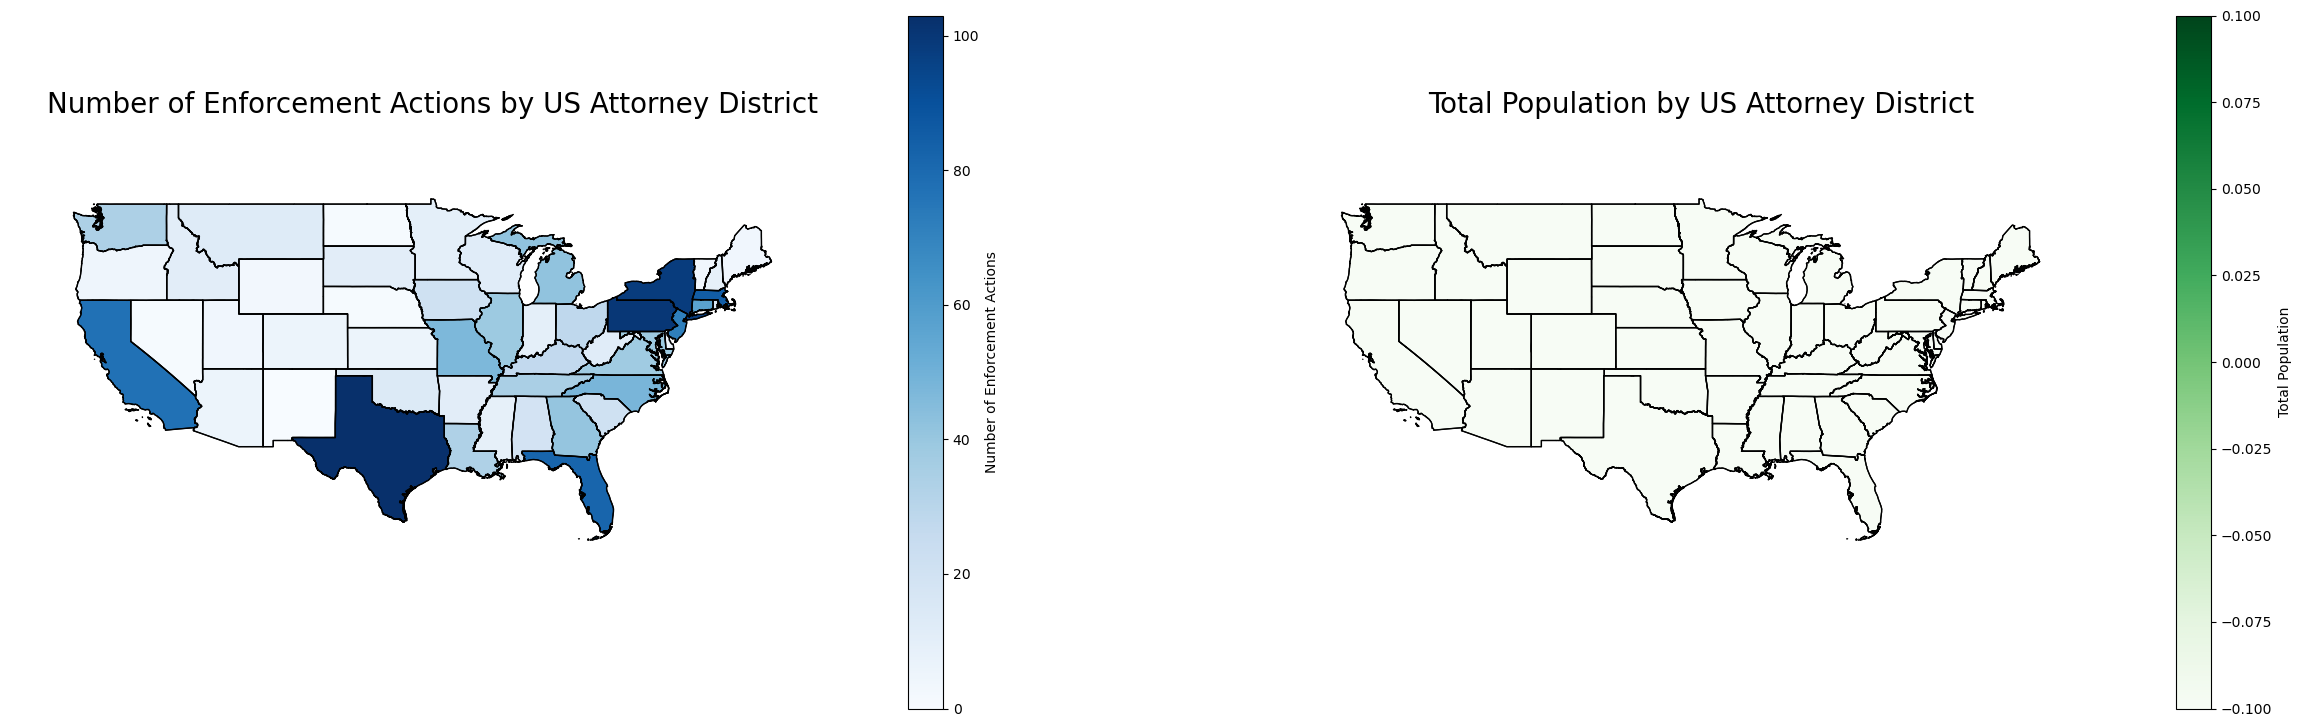

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Debug: Print sample population data
print("Sample population data:")
print(zip_population.head())

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Debug: Print sample ZIP GeoDataFrame after merge
print("Sample ZIP GeoDataFrame after merging with population data:")
print(gdf_zip.head())

# Ensure both GeoDataFrames have the same CRS
print("CRS before alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")
print(f"gdf_districts CRS: {gdf_districts.crs}")
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)
print("CRS after alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Debug: Print merged district GeoDataFrame with population data
print("Districts GeoDataFrame after merging with population data:")
print(gdf_districts[['District', 'Total_Population']].head())

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district and population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Plot the number of enforcement actions
gdf_merged.boundary.plot(ax=ax1, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)
ax1.set_title('Number of Enforcement Actions by US Attorney District', fontsize=20)
ax1.axis('off')

# Plot the total population
gdf_merged.boundary.plot(ax=ax2, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)
ax2.set_title('Total Population by US Attorney District', fontsize=20)
ax2.axis('off')

plt.show()

Sample population data:
  ZIP_CODE Population
0    raphy    !!Total
1    00601      17242
2    00602      37548
3    00603      49804
4    00606       5009
Sample ZIP_CODE from population data:
['raphy' '00601' '00602' '00603' '00606']
Sample GEOID from ZIP shapefile:
['00028' '00037' '00040' '00051' '00054']
Sample ZIP GeoDataFrame after merging with population data:
  STATEFP   STATENS     AFFGEOID  GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28  00028     MS     Mississippi   00   
1      37  01027616  0400000US37  00037     NC  North Carolina   00   
2      40  01102857  0400000US40  00040     OK        Oklahoma   00   
3      51  01779803  0400000US51  00051     VA        Virginia   00   
4      54  01779805  0400000US54  00054     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

         

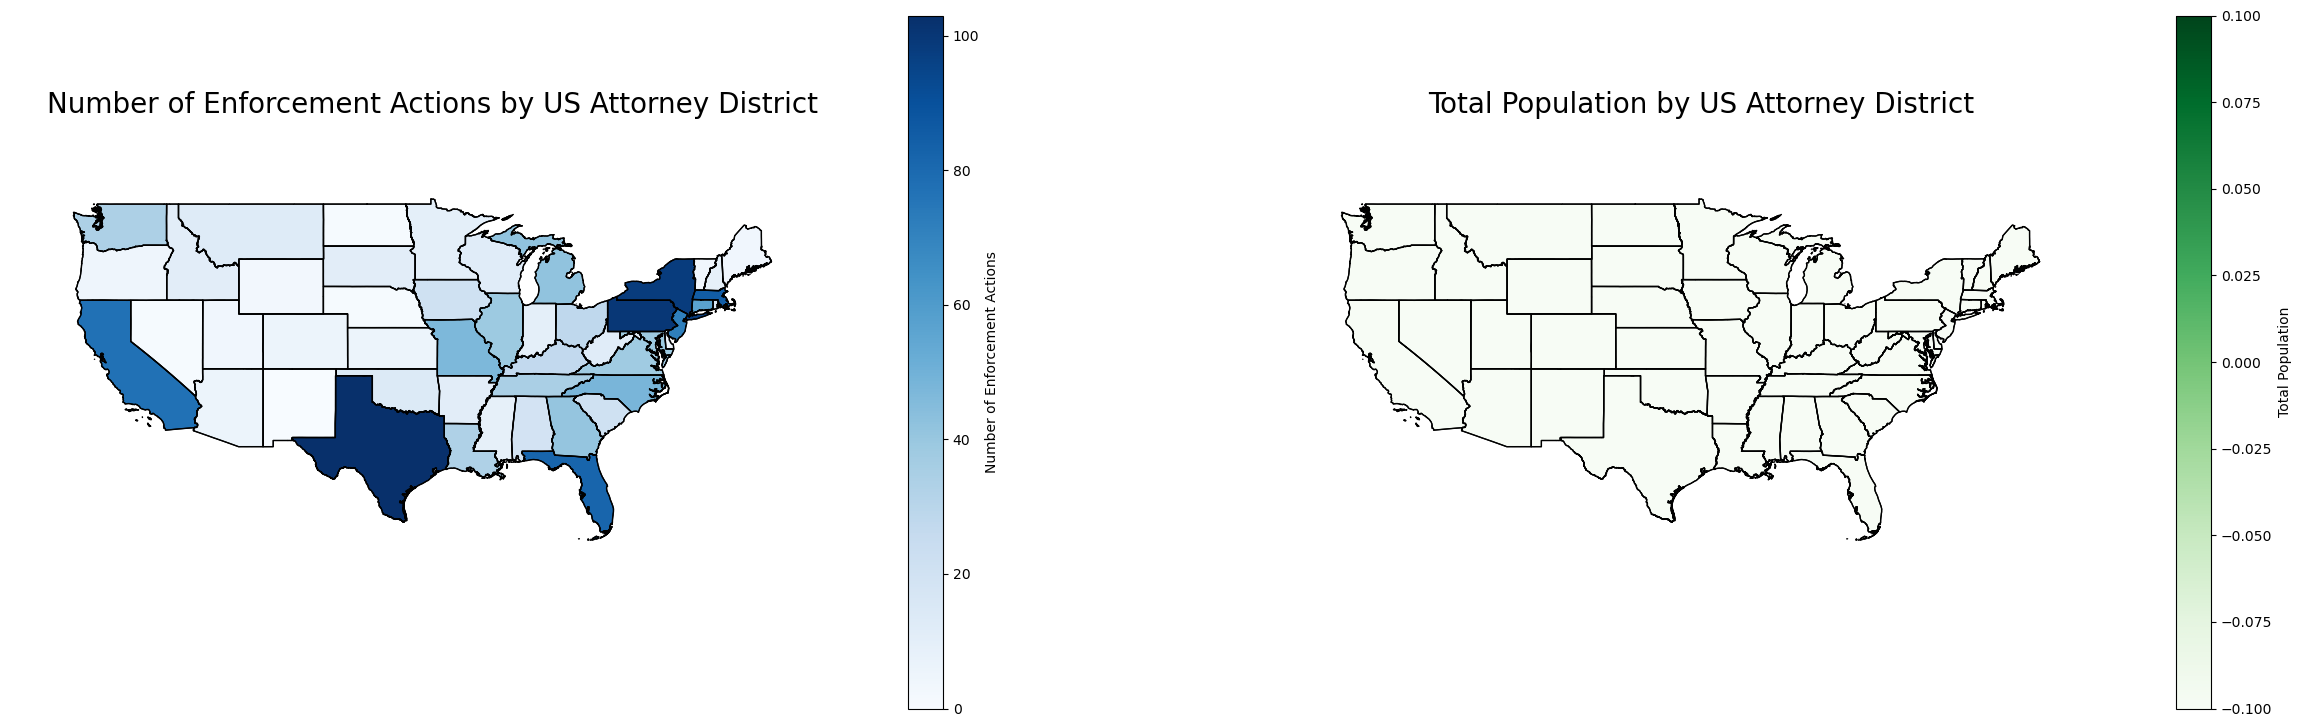

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Debug: Print sample population data
print("Sample population data:")
print(zip_population.head())

# Check ZIP_CODE and GEOID formats
gdf_zip['GEOID'] = gdf_zip['GEOID'].astype(str).str.zfill(5)
zip_population['ZIP_CODE'] = zip_population['ZIP_CODE'].astype(str).str.zfill(5)

# Debug: Print ZIP_CODE and GEOID samples
print("Sample ZIP_CODE from population data:")
print(zip_population['ZIP_CODE'].unique()[:5])
print("Sample GEOID from ZIP shapefile:")
print(gdf_zip['GEOID'].unique()[:5])

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Debug: Print sample ZIP GeoDataFrame after merge
print("Sample ZIP GeoDataFrame after merging with population data:")
print(gdf_zip.head())

# Ensure both GeoDataFrames have the same CRS
print("CRS before alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")
print(f"gdf_districts CRS: {gdf_districts.crs}")
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)
print("CRS after alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Debug: Print merged district GeoDataFrame with population data
print("Districts GeoDataFrame after merging with population data:")
print(gdf_districts[['District', 'Total_Population']].head())

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district and population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Plot the number of enforcement actions
gdf_merged.boundary.plot(ax=ax1, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)
ax1.set_title('Number of Enforcement Actions by US Attorney District', fontsize=20)
ax1.axis('off')

# Plot the total population
gdf_merged.boundary.plot(ax=ax2, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)
ax2.set_title('Total Population by US Attorney District', fontsize=20)
ax2.axis('off')

plt.show()

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/mnt/data/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/mnt/data/cb_2018_us_state_500k.shp"
zip_population_path = "/mnt/data/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Debug: Print sample population data
print("Sample population data:")
print(zip_population.head())

# Check ZIP_CODE and GEOID formats
gdf_zip['GEOID'] = gdf_zip['GEOID'].astype(str).str.zfill(5)
zip_population['ZIP_CODE'] = zip_population['ZIP_CODE'].astype(str).str.zfill(5)

# Debug: Print ZIP_CODE and GEOID samples
print("Sample ZIP_CODE from population data:")
print(zip_population['ZIP_CODE'].unique()[:5])
print("Sample GEOID from ZIP shapefile:")
print(gdf_zip['GEOID'].unique()[:5])

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Debug: Print sample ZIP GeoDataFrame after merge
print("Sample ZIP GeoDataFrame after merging with population data:")
print(gdf_zip.head())

# Ensure both GeoDataFrames have the same CRS
print("CRS before alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")
print(f"gdf_districts CRS: {gdf_districts.crs}")
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)
print("CRS after alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Debug: Print merged district GeoDataFrame with population data
print("Districts GeoDataFrame after merging with population data:")
print(gdf_districts[['District', 'Total_Population']].head())

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district and population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Plot the number of enforcement actions
gdf_merged.boundary.plot(ax=ax1, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)
ax1.set_title('Number of Enforcement Actions by US Attorney District', fontsize=20)
ax1.axis('off')

# Plot the total population
gdf_merged.boundary.plot(ax=ax2, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)
ax2.set_title('Total Population by US Attorney District', fontsize=20)
ax2.axis('off')

plt.show()

DataSourceError: /mnt/data/cb_2018_us_state_500k.shp: No such file or directory

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/mnt/data/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/mnt/data/cb_2018_us_state_500k.shp"
zip_population_path = "/mnt/data/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Debug: Print sample population data
print("Sample population data:")
print(zip_population.head())

# Check ZIP_CODE and GEOID formats
gdf_zip['GEOID'] = gdf_zip['GEOID'].astype(str).str.zfill(5)
zip_population['ZIP_CODE'] = zip_population['ZIP_CODE'].astype(str).str.zfill(5)

# Debug: Print ZIP_CODE and GEOID samples
print("Sample ZIP_CODE from population data:")
print(zip_population['ZIP_CODE'].unique()[:5])
print("Sample GEOID from ZIP shapefile:")
print(gdf_zip['GEOID'].unique()[:5])

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Debug: Print sample ZIP GeoDataFrame after merge
print("Sample ZIP GeoDataFrame after merging with population data:")
print(gdf_zip.head())

# Ensure both GeoDataFrames have the same CRS
print("CRS before alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")
print(f"gdf_districts CRS: {gdf_districts.crs}")
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)
print("CRS after alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Debug: Print merged district GeoDataFrame with population data
print("Districts GeoDataFrame after merging with population data:")
print(gdf_districts[['District', 'Total_Population']].head())

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district and population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Plot the number of enforcement actions
gdf_merged.boundary.plot(ax=ax1, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)
ax1.set_title('Number of Enforcement Actions by US Attorney District', fontsize=20)
ax1.axis('off')

# Plot the total population
gdf_merged.boundary.plot(ax=ax2, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)
ax2.set_title('Total Population by US Attorney District', fontsize=20)
ax2.axis('off')

plt.show()

DataSourceError: /mnt/data/cb_2018_us_state_500k.shp: No such file or directory

Sample population data:
  ZIP_CODE Population
0    raphy    !!Total
1    00601      17242
2    00602      37548
3    00603      49804
4    00606       5009
Sample ZIP_CODE from population data:
['raphy' '00601' '00602' '00603' '00606']
Sample GEOID from ZIP shapefile:
['00028' '00037' '00040' '00051' '00054']
Sample ZIP GeoDataFrame after merging with population data:
  STATEFP   STATENS     AFFGEOID  GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28  00028     MS     Mississippi   00   
1      37  01027616  0400000US37  00037     NC  North Carolina   00   
2      40  01102857  0400000US40  00040     OK        Oklahoma   00   
3      51  01779803  0400000US51  00051     VA        Virginia   00   
4      54  01779805  0400000US54  00054     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

         

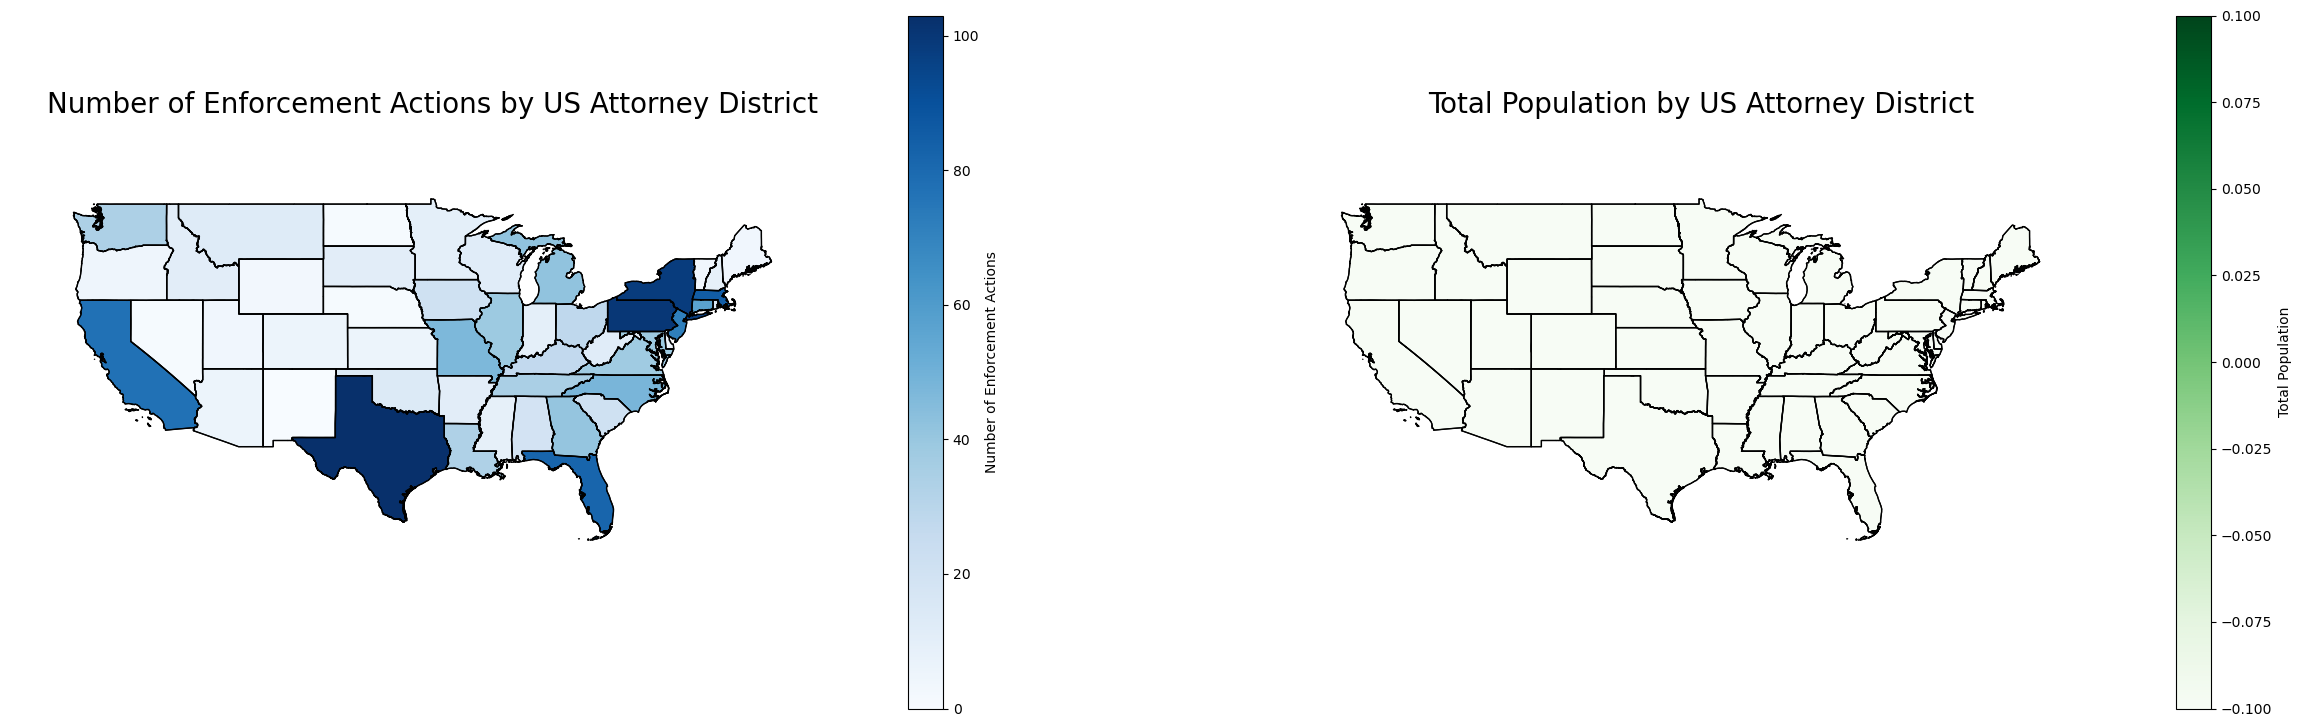

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Debug: Print sample population data
print("Sample population data:")
print(zip_population.head())

# Check ZIP_CODE and GEOID formats
gdf_zip['GEOID'] = gdf_zip['GEOID'].astype(str).str.zfill(5)
zip_population['ZIP_CODE'] = zip_population['ZIP_CODE'].astype(str).str.zfill(5)

# Debug: Print ZIP_CODE and GEOID samples
print("Sample ZIP_CODE from population data:")
print(zip_population['ZIP_CODE'].unique()[:5])
print("Sample GEOID from ZIP shapefile:")
print(gdf_zip['GEOID'].unique()[:5])

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Debug: Print sample ZIP GeoDataFrame after merge
print("Sample ZIP GeoDataFrame after merging with population data:")
print(gdf_zip.head())

# Ensure both GeoDataFrames have the same CRS
print("CRS before alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")
print(f"gdf_districts CRS: {gdf_districts.crs}")
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)
print("CRS after alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Debug: Print merged district GeoDataFrame with population data
print("Districts GeoDataFrame after merging with population data:")
print(gdf_districts[['District', 'Total_Population']].head())

# Merge the shapefile GeoDataFrame with the counts DataFrame
gdf_merged = gdf_districts.merge(district_counts, how='left', left_on='District', right_on='District')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

# Plot the choropleth of enforcement actions by district and population
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# Plot the number of enforcement actions
gdf_merged.boundary.plot(ax=ax1, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='Blues', linewidth=0.8, ax=ax1, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6})
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)
ax1.set_title('Number of Enforcement Actions by US Attorney District', fontsize=20)
ax1.axis('off')

# Plot the total population
gdf_merged.boundary.plot(ax=ax2, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax2, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)
ax2.set_title('Total Population by US Attorney District', fontsize=20)
ax2.axis('off')

plt.show()

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "/mnt/data/enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Debug: Print sample population data
print("Sample population data:")
print(zip_population.head())

# Check ZIP_CODE and GEOID formats
gdf_zip['GEOID'] = gdf_zip['GEOID'].astype(str).str.zfill(5)
zip_population['ZIP_CODE'] = zip_population['ZIP_CODE'].astype(str).str.zfill(5)

# Debug: Print ZIP_CODE and GEOID samples
print("Sample ZIP_CODE from population data:")
print(zip_population['ZIP_CODE'].unique()[:5])
print("Sample GEOID from ZIP shapefile:")
print(gdf_zip['GEOID'].unique()[:5])

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Debug: Print sample ZIP GeoDataFrame after merge
print("Sample ZIP GeoDataFrame after merging with population data:")
print(gdf_zip.head())

# Ensure both GeoDataFrames have the same CRS
print("CRS before alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")
print(f"gdf_districts CRS: {gdf_districts.crs}")
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)
print("CRS after alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Debug: Print merged district GeoDataFrame with population data
print("Districts GeoDataFrame after merging with population data:")
print(gdf_districts[['District', 'Total_Population']].head())

# Plot the total population by US Attorney District
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the total population
gdf_districts.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_districts.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
ax.set_title('Total Population by US Attorney District', fontsize=20)
ax.axis('off')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/enforcement_actions_2021_1.csv'

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "/mnt/data/enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Debug: Print sample population data
print("Sample population data:")
print(zip_population.head())

# Check ZIP_CODE and GEOID formats
gdf_zip['GEOID'] = gdf_zip['GEOID'].astype(str).str.zfill(5)
zip_population['ZIP_CODE'] = zip_population['ZIP_CODE'].astype(str).str.zfill(5)

# Debug: Print ZIP_CODE and GEOID samples
print("Sample ZIP_CODE from population data:")
print(zip_population['ZIP_CODE'].unique()[:5])
print("Sample GEOID from ZIP shapefile:")
print(gdf_zip['GEOID'].unique()[:5])

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Debug: Print sample ZIP GeoDataFrame after merge
print("Sample ZIP GeoDataFrame after merging with population data:")
print(gdf_zip.head())

# Ensure both GeoDataFrames have the same CRS
print("CRS before alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")
print(f"gdf_districts CRS: {gdf_districts.crs}")
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)
print("CRS after alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Debug: Print merged district GeoDataFrame with population data
print("Districts GeoDataFrame after merging with population data:")
print(gdf_districts[['District', 'Total_Population']].head())

# Plot the total population by US Attorney District
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the total population
gdf_districts.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_districts.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
ax.set_title('Total Population by US Attorney District', fontsize=20)
ax.axis('off')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/enforcement_actions_2021_1.csv'

Sample population data:
  ZIP_CODE Population
0    raphy    !!Total
1    00601      17242
2    00602      37548
3    00603      49804
4    00606       5009
Sample ZIP_CODE from population data:
['raphy' '00601' '00602' '00603' '00606']
Sample GEOID from ZIP shapefile:
['00028' '00037' '00040' '00051' '00054']
Sample ZIP GeoDataFrame after merging with population data:
  STATEFP   STATENS     AFFGEOID  GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28  00028     MS     Mississippi   00   
1      37  01027616  0400000US37  00037     NC  North Carolina   00   
2      40  01102857  0400000US40  00040     OK        Oklahoma   00   
3      51  01779803  0400000US51  00051     VA        Virginia   00   
4      54  01779805  0400000US54  00054     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

         

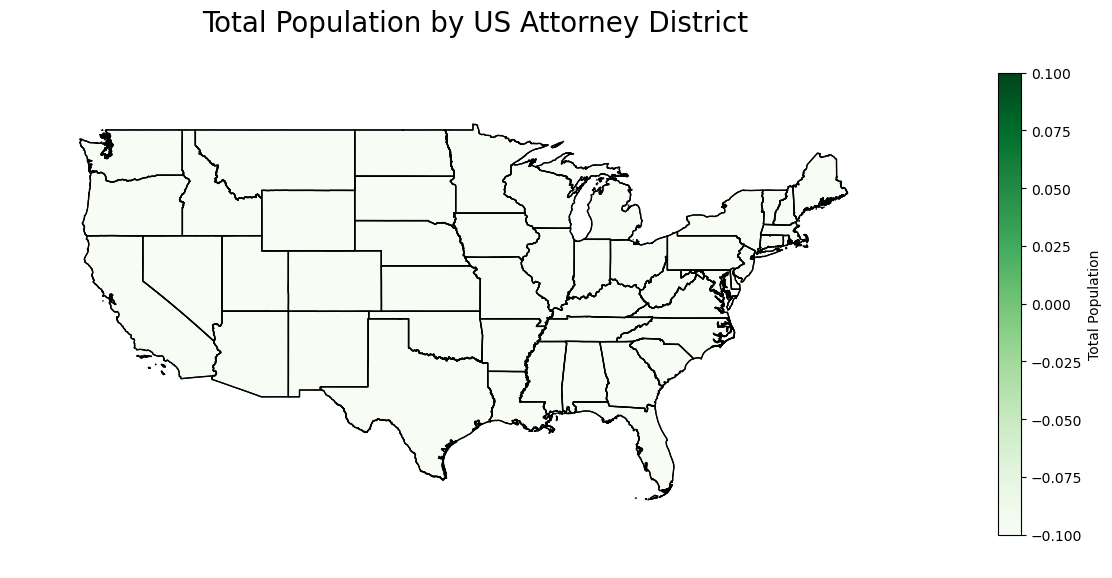

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

# Extract district names from agency info
data['District'] = data['Agency'].apply(lambda x: re.search(r'District of [A-Za-z ]+', x).group(0) if pd.notnull(x) and 'District' in x else None)

# Drop rows with missing district names
district_data = data.dropna(subset=['District']).copy()

# Clean district names
district_data['District'] = district_data['District'].str.replace('U\.S\. Attorney\'s Office, ', '').str.replace('District of ', '').str.strip()

# Aggregate enforcement actions by district
district_counts = district_data['District'].value_counts().reset_index()
district_counts.columns = ['District', 'Count']

# Load the shapefile for US Attorney Districts
shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

# Clean the district names in the shapefile to match our dataset
gdf_districts['District'] = gdf_districts['NAME'].str.strip()

# Load the ZIP code shapefile and population data
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

# Load ZIP code shapefile
gdf_zip = gpd.read_file(zip_shapefile_path)

# Load population data
zip_population = pd.read_csv(zip_population_path, dtype={'GEO_ID': str})
# Extract the last 5 characters from GEO_ID to get ZIP_CODE
zip_population['ZIP_CODE'] = zip_population['GEO_ID'].str[-5:]
# Select ZIP_CODE and Population columns
zip_population = zip_population[['ZIP_CODE', 'P1_001N']]
zip_population.columns = ['ZIP_CODE', 'Population']

# Debug: Print sample population data
print("Sample population data:")
print(zip_population.head())

# Check ZIP_CODE and GEOID formats
gdf_zip['GEOID'] = gdf_zip['GEOID'].astype(str).str.zfill(5)
zip_population['ZIP_CODE'] = zip_population['ZIP_CODE'].astype(str).str.zfill(5)

# Debug: Print ZIP_CODE and GEOID samples
print("Sample ZIP_CODE from population data:")
print(zip_population['ZIP_CODE'].unique()[:5])
print("Sample GEOID from ZIP shapefile:")
print(gdf_zip['GEOID'].unique()[:5])

# Merge ZIP code shapefile with population data
gdf_zip = gdf_zip.merge(zip_population, how='left', left_on='GEOID', right_on='ZIP_CODE')

# Fill NaN population values with 0
gdf_zip['Population'] = gdf_zip['Population'].fillna(0)

# Debug: Print sample ZIP GeoDataFrame after merge
print("Sample ZIP GeoDataFrame after merging with population data:")
print(gdf_zip.head())

# Ensure both GeoDataFrames have the same CRS
print("CRS before alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")
print(f"gdf_districts CRS: {gdf_districts.crs}")
if gdf_zip.crs != gdf_districts.crs:
    gdf_zip = gdf_zip.to_crs(gdf_districts.crs)
print("CRS after alignment:")
print(f"gdf_zip CRS: {gdf_zip.crs}")

# Conduct spatial join between ZIP code shapefile and district shapefile
zip_district_join = gpd.sjoin(gdf_zip, gdf_districts, how='inner', op='intersects')

# Check the number of matched records
print(f"Number of records after spatial join: {len(zip_district_join)}")
print("Sample of spatial join result:")
print(zip_district_join.head())

# Aggregate population by district
district_population = zip_district_join.groupby('District')['Population'].sum().reset_index()
district_population.columns = ['District', 'Total_Population']

# Print aggregated population data
print("Aggregated Population Data:")
print(district_population.head())

# Merge population data with district GeoDataFrame
gdf_districts = gdf_districts.merge(district_population, how='left', on='District')
gdf_districts['Total_Population'] = gdf_districts['Total_Population'].fillna(0)

# Debug: Print merged district GeoDataFrame with population data
print("Districts GeoDataFrame after merging with population data:")
print(gdf_districts[['District', 'Total_Population']].head())

# Plot the total population by US Attorney District
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the total population
gdf_districts.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_districts.plot(column='Total_Population', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Total Population",
                             'shrink': 0.6})
ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
ax.set_title('Total Population by US Attorney District', fontsize=20)
ax.axis('off')

plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 Zip Code Shapefile
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_gdf = gpd.read_file(zip_shapefile_path)

# 确认数据加载成功
print("ZIP Code Shapefile Loaded:")
print(zip_gdf.head())

# 2. 加载 District Shapefile
district_shapefile_path = "/path/to/district_shapefile.shp"  # 替换为实际路径
district_gdf = gpd.read_file(district_shapefile_path)

# 确认数据加载成功
print("District Shapefile Loaded:")
print(district_gdf.head())

# 3. 确保两者坐标系一致
zip_gdf = zip_gdf.to_crs(district_gdf.crs)

# 4. 执行空间连接 (Spatial Join)
joined_gdf = gpd.sjoin(zip_gdf, district_gdf, how="inner", op="intersects")

# 检查空间连接结果
print("Spatial Join Results:")
print(joined_gdf.head())

# 5. 按 District 聚合人口数据
# 确保 TOTAL_POPULATION 列存在，填充缺失值
joined_gdf['TOTAL_POPULATION'] = joined_gdf['TOTAL_POPULATION'].fillna(0)

# 按 District 聚合
district_population = joined_gdf.groupby('district_column')['TOTAL_POPULATION'].sum().reset_index()

# 查看聚合结果
print("Aggregated Population by District:")
print(district_population.head())

# 6. 保存结果到 CSV（可选）
district_population.to_csv("/Users/hahei/Desktop/district_population.csv", index=False)
print("District population data saved to '/Users/hahei/Desktop/district_population.csv'")

ZIP Code Shapefile Loaded:
  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  


DataSourceError: /path/to/district_shapefile.shp: No such file or directory

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 Zip Code Shapefile
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_gdf = gpd.read_file(zip_shapefile_path)

# 确认数据加载成功
print("ZIP Code Shapefile Loaded:")
print(zip_gdf.head())

# 2. 加载 District Shapefile
district_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/district_shapefile.shp"  # 替换为实际路径
district_gdf = gpd.read_file(district_shapefile_path)

# 确认数据加载成功
print("District Shapefile Loaded:")
print(district_gdf.head())

# 3. 确保两者坐标系一致
zip_gdf = zip_gdf.to_crs(district_gdf.crs)

# 4. 执行空间连接 (Spatial Join)
joined_gdf = gpd.sjoin(zip_gdf, district_gdf, how="inner", op="intersects")

# 检查空间连接结果
print("Spatial Join Results:")
print(joined_gdf.head())

# 5. 按 District 聚合人口数据
# 确保 TOTAL_POPULATION 列存在，填充缺失值
joined_gdf['TOTAL_POPULATION'] = joined_gdf['TOTAL_POPULATION'].fillna(0)

# 按 District 聚合
district_population = joined_gdf.groupby('district_column')['TOTAL_POPULATION'].sum().reset_index()

# 查看聚合结果
print("Aggregated Population by District:")
print(district_population.head())

# 6. 保存结果到 CSV（可选）
district_population.to_csv("/Users/hahei/Desktop/district_population.csv", index=False)
print("District population data saved to '/Users/hahei/Desktop/district_population.csv'")

ZIP Code Shapefile Loaded:
  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  


DataSourceError: /Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/district_shapefile.shp: No such file or directory

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 Zip Code Shapefile
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_gdf = gpd.read_file(zip_shapefile_path)

# 检查 Zip Shapefile 数据
print("ZIP Code Shapefile Loaded:")
print(zip_gdf.head())

# 2. 加载 District CSV 文件
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/DECENNIALDHC2020.P1-Data.csv"  # 替换为实际路径
district_df = pd.read_csv(district_csv_path)

# 检查 District 数据
print("District CSV Loaded:")
print(district_df.head())

# 3. 清理 District CSV 的列名
# 假设列名为 'NAME'（对应 District Name）和 'P1_001N'（对应人口总数）
district_df = district_df.rename(columns={
    'NAME': 'District_Name',
    'P1_001N': 'TOTAL_POPULATION'
})

# 提取 Zip Code 信息
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')  # 提取 5 位 Zip Code

# 确保 ZIP 列和 shapefile 的格式一致
zip_gdf['ZIP'] = zip_gdf['ZIP'].astype(str).str.zfill(5)
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 4. 合并 Zip Shapefile 和 District CSV
merged_gdf = zip_gdf.merge(district_df, on='ZIP', how='inner')

# 检查合并结果
print("Merged GeoDataFrame:")
print(merged_gdf.head())

# 5. 按 District 聚合人口
# 假设 District 名称字段为 'District_Name'
aggregated_population = merged_gdf.groupby('District_Name')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by District:")
print(aggregated_population.head())

# 6. 保存结果到 CSV
output_path = "/Users/hahei/Desktop/district_population.csv"
aggregated_population.to_csv(output_path, index=False)
print(f"District population data saved to {output_path}")

ZIP Code Shapefile Loaded:
  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  


FileNotFoundError: [Errno 2] No such file or directory: '/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/DECENNIALDHC2020.P1-Data.csv'

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 Zip Code Shapefile
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_gdf = gpd.read_file(zip_shapefile_path)

# 检查 Zip Shapefile 数据
print("ZIP Code Shapefile Loaded:")
print(zip_gdf.head())

# 2. 加载 District CSV 文件
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 检查 District 数据
print("District CSV Loaded:")
print(district_df.head())

# 3. 清理 District CSV 的列名
# 假设列名为 'NAME'（对应 District Name）和 'P1_001N'（对应人口总数）
district_df = district_df.rename(columns={
    'NAME': 'District_Name',
    'P1_001N': 'TOTAL_POPULATION'
})

# 提取 ZIP Code 信息
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')  # 提取 5 位 Zip Code

# 确保 ZIP 列和 shapefile 的格式一致
zip_gdf['ZIP'] = zip_gdf['ZIP'].astype(str).str.zfill(5)
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 4. 合并 Zip Shapefile 和 District CSV
merged_gdf = zip_gdf.merge(district_df, on='ZIP', how='inner')

# 检查合并结果
print("Merged GeoDataFrame:")
print(merged_gdf.head())

# 5. 按 District 聚合人口
# 假设 District 名称字段为 'District_Name'
aggregated_population = merged_gdf.groupby('District_Name')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by District:")
print(aggregated_population.head())

# 6. 保存结果到 CSV
output_path = "/Users/hahei/Desktop/district_population.csv"
aggregated_population.to_csv(output_path, index=False)
print(f"District population data saved to {output_path}")

ZIP Code Shapefile Loaded:
  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  


FileNotFoundError: [Errno 2] No such file or directory: '/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/DECENNIALDHC2020.P1-Data.csv'

In [ ]:
ls /Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/DECENNIALDHC2020.P1-Data.csv


ls: /Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/DECENNIALDHC2020.P1-Data.csv: No such file or directory


In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 Zip Code Shapefile
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_gdf = gpd.read_file(zip_shapefile_path)

# 检查 Zip Shapefile 数据
print("ZIP Code Shapefile Loaded:")
print(zip_gdf.head())

# 2. 加载 District CSV 文件
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 检查 District 数据
print("District CSV Loaded:")
print(district_df.head())

# 3. 清理 District CSV 的列名
# 假设列名为 'NAME'（对应 District Name）和 'P1_001N'（对应人口总数）
district_df = district_df.rename(columns={
    'NAME': 'District_Name',
    'P1_001N': 'TOTAL_POPULATION'
})

# 提取 ZIP Code 信息
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')  # 提取 5 位 Zip Code

# 确保 ZIP 列和 shapefile 的格式一致
zip_gdf['ZIP'] = zip_gdf['ZIP'].astype(str).str.zfill(5)
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 4. 合并 Zip Shapefile 和 District CSV
merged_gdf = zip_gdf.merge(district_df, on='ZIP', how='inner')

# 检查合并结果
print("Merged GeoDataFrame:")
print(merged_gdf.head())

# 5. 按 District 聚合人口
# 假设 District 名称字段为 'District_Name'
aggregated_population = merged_gdf.groupby('District_Name')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by District:")
print(aggregated_population.head())

# 6. 保存结果到 CSV
output_path = "/Users/hahei/Desktop/district_population.csv"
aggregated_population.to_csv(output_path, index=False)
print(f"District population data saved to {output_path}")

ZIP Code Shapefile Loaded:
  STATEFP   STATENS     AFFGEOID GEOID STUSPS            NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER  \
0  121533519481   3926919758   
1  125923656064  13466071395   
2  177662925723   3374587997   
3  102257717110   8528531774   
4   62266474513    489028543   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...  
4  POLYGON ((-82.64320 38.16909, -82.64300 38.169...  
District CSV Loaded:
        

KeyError: 'ZIP'

In [ ]:
print(zip_gdf.columns)  # 查看所有列名


Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载人口 CSV 数据
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 重命名列名
district_df = district_df.rename(columns={
    'NAME': 'District_Name',
    'P1_001N': 'TOTAL_POPULATION'
})

# 提取 ZIP Code 信息
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')  # 提取 5 位 ZIP Code

# 2. 加载州级 Shapefile
state_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
state_gdf = gpd.read_file(state_shapefile_path)

# 聚合人口到州级别
district_df['STATE_NAME'] = district_df['District_Name'].str.split().str[-1]  # 假设州名是 District_Name 的最后一部分
state_population = district_df.groupby('STATE_NAME')['TOTAL_POPULATION'].sum().reset_index()

# 检查结果
print("Aggregated Population by State:")
print(state_population.head())

# 3. 合并州级 Shapefile 和人口数据
state_gdf = state_gdf.rename(columns={'NAME': 'STATE_NAME'})
merged_gdf = state_gdf.merge(state_population, on='STATE_NAME', how='left')

# 4. 保存合并结果（可选）
output_path = "/Users/hahei/Desktop/state_population.geojson"
merged_gdf.to_file(output_path, driver="GeoJSON")
print(f"State population data saved to {output_path}")

Aggregated Population by State:
  STATE_NAME TOTAL_POPULATION
0      00601            17242
1      00602            37548
2      00603            49804
3      00606             5009
4      00610            25731
State population data saved to /Users/hahei/Desktop/state_population.geojson


In [ ]:
import geopandas as gpd

# 加载 geojson 文件
geojson_path = "/Users/hahei/Desktop/state_population.geojson"
state_gdf = gpd.read_file(geojson_path)

# 查看文件内容
print("Columns in the GeoJSON file:")
print(state_gdf.columns)

# 查看前几行数据
print("Sample data from the GeoJSON file:")
print(state_gdf.head())


Columns in the GeoJSON file:
Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'STATE_NAME',
       'LSAD', 'ALAND', 'AWATER', 'TOTAL_POPULATION', 'geometry'],
      dtype='object')
Sample data from the GeoJSON file:
  STATEFP   STATENS     AFFGEOID GEOID STUSPS      STATE_NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER TOTAL_POPULATION  \
0  121533519481   3926919758             None   
1  125923656064  13466071395             None   
2  177662925723   3374587997             None   
3  102257717110   8528531774             None   
4   62266474513    489028543             None   

                                            geometry  
0 

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 GeoJSON 文件
geojson_path = "/Users/hahei/Desktop/state_population.geojson"
state_gdf = gpd.read_file(geojson_path)

# 检查数据
print("Loaded GeoJSON file:")
print(state_gdf.head())

# 2. 加载人口数据（CSV 文件）
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 重命名列名
district_df = district_df.rename(columns={
    'NAME': 'District_Name',
    'P1_001N': 'TOTAL_POPULATION'
})

# 提取 ZIP Code 信息（从 District_Name 中提取 5 位 ZIP Code）
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')

# 3. 检查州匹配逻辑（假设直接按 ZIP Code 提取州信息）
# 确保数据准备完成，按 ZIP Code 匹配州
state_zip_mapping = state_gdf[['STATEFP', 'STATE_NAME']]  # 假设州代码是 STATEFP
district_df = district_df.merge(state_zip_mapping, how='left', left_on='ZIP', right_on='STATEFP')

# 按州（STATE_NAME）聚合人口
state_population = district_df.groupby('STATE_NAME')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by State:")
print(state_population.head())

# 4. 将人口数据合并到 GeoJSON
state_gdf = state_gdf.merge(state_population, on='STATE_NAME', how='left')

# 5. 保存更新后的 GeoJSON 文件
output_path = "/Users/hahei/Desktop/updated_state_population.geojson"
state_gdf.to_file(output_path, driver="GeoJSON")
print(f"Updated GeoJSON file saved to {output_path}")


Loaded GeoJSON file:
  STATEFP   STATENS     AFFGEOID GEOID STUSPS      STATE_NAME LSAD  \
0      28  01779790  0400000US28    28     MS     Mississippi   00   
1      37  01027616  0400000US37    37     NC  North Carolina   00   
2      40  01102857  0400000US40    40     OK        Oklahoma   00   
3      51  01779803  0400000US51    51     VA        Virginia   00   
4      54  01779805  0400000US54    54     WV   West Virginia   00   

          ALAND       AWATER TOTAL_POPULATION  \
0  121533519481   3926919758             None   
1  125923656064  13466071395             None   
2  177662925723   3374587997             None   
3  102257717110   8528531774             None   
4   62266474513    489028543             None   

                                            geometry  
0  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...  
1  MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...  
2  POLYGON ((-103.00257 36.52659, -103.00219 36.6...  
3  MULTIPOLYGON (((-75.74241 37.80835, -75.

In [ ]:
import pandas as pd

# 加载文件
district_csv_path = "/mnt/data/US_Attorney_Districts_Shapefile_simplified_20241108.csv"
district_data = pd.read_csv(district_csv_path)

# 查看文件结构
print("Columns in the new CSV file:")
print(district_data.columns)

# 查看前几行数据
print("Sample data from the new CSV file:")
print(district_data.head())


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/US_Attorney_Districts_Shapefile_simplified_20241108.csv'

In [ ]:
import pandas as pd

# 加载文件
district_csv_path = "/Users/hahei/Desktop/US_Attorney_Districts_Shapefile_simplified_20241108.csv"
district_data = pd.read_csv(district_csv_path)

# 查看文件结构
print("Columns in the new CSV file:")
print(district_data.columns)

# 查看前几行数据
print("Sample data from the new CSV file:")
print(district_data.head())


Columns in the new CSV file:
Index(['the_geom', 'STATEFP', 'Judicial District ', 'ALAND', 'AWATER', 'STATE',
       'CHIEF_JUDG', 'NOMINATING', 'TERM_AS_CH', 'Shape_Leng', 'Shape_Area',
       'ABBR', 'DISTRICT_N', 'Shape__Are', 'Shape__Len'],
      dtype='object')
Sample data from the new CSV file:
                                            the_geom  STATEFP  \
0  MULTIPOLYGON (((-89.48247982196031 36.50213778...       21   
1  MULTIPOLYGON (((-84.62011661455777 39.07346450...       21   
2  MULTIPOLYGON (((-85.86280909557978 40.46475869...       18   
3  MULTIPOLYGON (((-85.33828446306566 33.49470634...        1   
4  MULTIPOLYGON (((-88.0868170813849 30.259869545...        1   

             Judicial District         ALAND      AWATER     STATE  \
0  Western District of Kentucky  49705549117  1651516493  Kentucky   
1  Eastern District of Kentucky  52573941555   723821262  Kentucky   
2  Southern District of Indiana  58245165485   594117585   Indiana   
3    Middle District of Alab

In [ ]:
import pandas as pd

# 1. 加载司法区 CSV 文件
district_csv_path = "/Users/hahei/Desktop/US_Attorney_Districts_Shapefile_simplified_20241108.csv"
district_data = pd.read_csv(district_csv_path)

# 提取关键列
district_mapping = district_data[['STATE', 'Judicial District ', 'STATEFP']].drop_duplicates()

# 2. 加载人口数据
population_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
population_data = pd.read_csv(population_csv_path)

# 重命名列名
population_data = population_data.rename(columns={
    'NAME': 'District_Name',
    'P1_001N': 'TOTAL_POPULATION'
})

# 提取 ZIP Code 信息
population_data['ZIP'] = population_data['District_Name'].str.extract(r'(\d{5})')

# 假设有 ZIP Code 和州映射表，此处匹配州信息
# 加载 ZIP Code 和州映射表
zip_to_state_path = "/path/to/ZIP_to_State.csv"  # 替换为实际路径
zip_to_state = pd.read_csv(zip_to_state_path)

# 合并人口数据与州信息
population_data = population_data.merge(zip_to_state, on='ZIP', how='left')

# 3. 合并司法区信息
# 使用州信息（STATE）匹配人口数据到司法区
population_data = population_data.merge(district_mapping, on='STATE', how='left')

# 按司法区（Judicial District ）聚合人口数据
district_population = population_data.groupby('Judicial District ')['TOTAL_POPULATION'].sum().reset_index()

# 检查结果
print("Aggregated Population by Judicial District:")
print(district_population.head())

# 4. 保存结果
output_path = "/Users/hahei/Desktop/judicial_district_population.csv"
district_population.to_csv(output_path, index=False)
print(f"Judicial district population data saved to {output_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/ZIP_to_State.csv'

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZIP Code Shapefile
zip_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
zip_gdf = gpd.read_file(zip_shapefile_path)

# 查看 GEOID 字段样例
print("Sample GEOID in Shapefile:")
print(zip_gdf['GEOID'].head())

# 2. 加载 District CSV
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code
district_df['ZIP'] = district_df['NAME'].str.extract(r'(\d{5})')

# 查看 ZIP Code 样例
print("Sample ZIP Code in District CSV:")
print(district_df['ZIP'].head())

# 3. 确认是否可以匹配
# 对 ZIP Code 和 GEOID 进行比较，验证匹配性
matches = zip_gdf['GEOID'].isin(district_df['ZIP'])
print(f"Number of matches between GEOID and ZIP: {matches.sum()}")

# 如果 matches.sum() > 0，则说明部分 ZIP Code 和 GEOID 可以直接匹配


Sample GEOID in Shapefile:
0    28
1    37
2    40
3    51
4    54
Name: GEOID, dtype: object
Sample ZIP Code in District CSV:
0      NaN
1    00601
2    00602
3    00603
4    00606
Name: ZIP, dtype: object
Number of matches between GEOID and ZIP: 0


In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZCTA Shapefile
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 检查 ZCTA 数据结构
print("ZCTA Shapefile Columns:")
print(zcta_gdf.columns)
print("Sample data from ZCTA Shapefile:")
print(zcta_gdf[['GEOID']].head())

# 确保 GEOID 格式为 5 位字符串
zcta_gdf['GEOID'] = zcta_gdf['GEOID'].astype(str).str.zfill(5)

# 2. 加载 District CSV 文件
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code 并确保格式一致
district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 检查 District 数据结构
print("District CSV Columns:")
print(district_df.columns)
print("Sample data from District CSV:")
print(district_df[['ZIP', 'TOTAL_POPULATION']].head())

# 3. 合并 ZCTA 和 District 数据
merged_gdf = zcta_gdf.merge(district_df, left_on='GEOID', right_on='ZIP', how='inner')

# 检查合并结果
print("Merged DataFrame Columns:")
print(merged_gdf.columns)
print("Sample data from merged DataFrame:")
print(merged_gdf.head())

# 4. 保存合并后的结果
output_path = "/Users/hahei/Desktop/merged_zcta_population.geojson"
merged_gdf.to_file(output_path, driver="GeoJSON")
print(f"Merged data saved to {output_path}")

ZCTA Shapefile Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Sample data from ZCTA Shapefile:


KeyError: "None of [Index(['GEOID'], dtype='object')] are in the [columns]"

In [ ]:
import geopandas as gpd

# 加载 ZCTA Shapefile
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 列出所有列名
print("ZCTA Shapefile Columns:")
print(zcta_gdf.columns)

# 查看前几行数据
print("Sample data from ZCTA Shapefile:")
print(zcta_gdf.head())


ZCTA Shapefile Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Sample data from ZCTA Shapefile:
  ZCTA5CE10      AFFGEOID10 GEOID10    ALAND10  AWATER10  \
0     36083  8600000US36083   36083  659750662   5522919   
1     35441  8600000US35441   35441  172850429   8749105   
2     35051  8600000US35051   35051  280236456   5427285   
3     35121  8600000US35121   35121  372736030   5349303   
4     35058  8600000US35058   35058  178039922   3109259   

                                            geometry  
0  MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...  
1  MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...  
2  POLYGON ((-86.74384 33.25002, -86.73802 33.251...  
3  POLYGON ((-86.58527 33.94743, -86.58033 33.948...  
4  MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...  


In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZCTA Shapefile
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 检查 ZCTA 数据结构
print("ZCTA Shapefile Columns:")
print(zcta_gdf.columns)

# 格式化 ZCTA5CE10 为 5 位 ZIP Code
zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

# 2. 加载 District CSV 文件
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code 并确保格式一致
district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 检查 District 数据结构
print("District CSV Columns:")
print(district_df.columns)
print("Sample data from District CSV:")
print(district_df[['ZIP', 'TOTAL_POPULATION']].head())

# 3. 合并 ZCTA 和 District 数据
merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

# 检查合并结果
print("Merged DataFrame Columns:")
print(merged_gdf.columns)
print("Sample data from merged DataFrame:")
print(merged_gdf.head())

# 4. 保存合并后的结果
output_path = "/Users/hahei/Desktop/merged_zcta_population.geojson"
merged_gdf.to_file(output_path, driver="GeoJSON")
print(f"Merged data saved to {output_path}")

ZCTA Shapefile Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
District CSV Columns:
Index(['GEO_ID', 'District_Name', 'TOTAL_POPULATION', 'Unnamed: 3', 'ZIP'], dtype='object')
Sample data from District CSV:
     ZIP TOTAL_POPULATION
0  00nan          !!Total
1  00601            17242
2  00602            37548
3  00603            49804
4  00606             5009
Merged DataFrame Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10', 'geometry',
       'GEO_ID', 'District_Name', 'TOTAL_POPULATION', 'Unnamed: 3', 'ZIP'],
      dtype='object')
Sample data from merged DataFrame:
  ZCTA5CE10      AFFGEOID10 GEOID10    ALAND10  AWATER10  \
0     36083  8600000US36083   36083  659750662   5522919   
1     35441  8600000US35441   35441  172850429   8749105   
2     35051  8600000US35051   35051  280236456   5427285   
3     35121  8600000US35121   35121  372736030   5349303   
4     35058  8600000US3505

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZCTA Shapefile (ZIP Code 区域边界文件)
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 格式化 ZIP Code 列为 5 位字符串
zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

# 检查 ZCTA 数据
print("ZCTA Shapefile Columns:")
print(zcta_gdf.columns)
print("Sample data from ZCTA Shapefile:")
print(zcta_gdf[['ZCTA5CE10', 'geometry']].head())

# 2. 加载 District CSV 文件 (包含 ZIP Code 和人口数据)
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code 并确保格式一致
district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 检查 District 数据
print("District CSV Columns:")
print(district_df.columns)
print("Sample data from District CSV:")
print(district_df[['ZIP', 'TOTAL_POPULATION']].head())

# 转换人口数据为数值类型，无法转换的填充为 0
district_df['TOTAL_POPULATION'] = pd.to_numeric(district_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 3. 合并 ZCTA 和 District 数据
merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

# 检查合并结果
print("Merged DataFrame Columns:")
print(merged_gdf.columns)
print("Sample data from merged DataFrame:")
print(merged_gdf.head())

# 4. 加载 District Shapefile (司法区边界文件)
district_shapefile_path = "/Users/hahei/Desktop/US_Attorney_Districts_Shapefile_simplified_20241108.csv"
district_shape_df = gpd.read_file(district_shapefile_path)

# 检查 District Shapefile 数据
print("District Shapefile Columns:")
print(district_shape_df.columns)

# 确保两者的坐标系一致
zcta_gdf = zcta_gdf.to_crs(district_shape_df.crs)

# 5. 执行空间连接 (Spatial Join)
# 将 ZCTA 数据与司法区边界文件进行空间匹配
spatial_joined_gdf = gpd.sjoin(merged_gdf, district_shape_df, how='inner', op='intersects')

# 检查空间连接结果
print("Spatially Joined DataFrame Columns:")
print(spatial_joined_gdf.columns)
print("Sample data from spatially joined DataFrame:")
print(spatial_joined_gdf.head())

# 6. 按 District 聚合人口数据
district_population = spatial_joined_gdf.groupby('Judicial District ')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by District:")
print(district_population.head())

# 7. 保存结果到文件
output_path = "/Users/hahei/Desktop/aggregated_district_population.csv"
district_population.to_csv(output_path, index=False)
print(f"Aggregated population data saved to {output_path}")

ZCTA Shapefile Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Sample data from ZCTA Shapefile:
  ZCTA5CE10                                           geometry
0     36083  MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...
1     35441  MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...
2     35051  POLYGON ((-86.74384 33.25002, -86.73802 33.251...
3     35121  POLYGON ((-86.58527 33.94743, -86.58033 33.948...
4     35058  MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...
District CSV Columns:
Index(['GEO_ID', 'District_Name', 'TOTAL_POPULATION', 'Unnamed: 3', 'ZIP'], dtype='object')
Sample data from District CSV:
     ZIP TOTAL_POPULATION
0  00nan          !!Total
1  00601            17242
2  00602            37548
3  00603            49804
4  00606             5009
Merged DataFrame Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10', 'geometry',
       'GEO_ID', 'District_Name', 'TOTAL_POPULAT

DataSourceError: /Users/hahei/Desktop/US_Attorney_Districts_Shapefile_simplified_20241108.csv: No such file or directory

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZCTA Shapefile (ZIP Code 区域边界文件)
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 格式化 ZIP Code 列为 5 位字符串
zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

# 检查 ZCTA 数据
print("ZCTA Shapefile Columns:")
print(zcta_gdf.columns)
print("Sample data from ZCTA Shapefile:")
print(zcta_gdf[['ZCTA5CE10', 'geometry']].head())

# 2. 加载 District CSV 文件 (包含 ZIP Code 和人口数据)
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code 并确保格式一致
district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 转换人口数据为数值类型，无法转换的填充为 0
district_df['TOTAL_POPULATION'] = pd.to_numeric(district_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 检查 District 数据
print("District CSV Columns:")
print(district_df.columns)
print("Sample data from District CSV:")
print(district_df[['ZIP', 'TOTAL_POPULATION']].head())

# 3. 合并 ZCTA 和 District 数据
merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

# 检查合并结果
print("Merged DataFrame Columns:")
print(merged_gdf.columns)
print("Sample data from merged DataFrame:")
print(merged_gdf.head())

# 4. 按 ZIP Code 汇总人口数据
zip_population = merged_gdf.groupby('ZCTA5CE10')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by ZIP Code:")
print(zip_population.head())

# 5. 保存结果到文件
output_path = "/Users/hahei/Desktop/aggregated_zip_population.csv"
zip_population.to_csv(output_path, index=False)
print(f"Aggregated ZIP Code population data saved to {output_path}")

ZCTA Shapefile Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Sample data from ZCTA Shapefile:
  ZCTA5CE10                                           geometry
0     36083  MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...
1     35441  MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...
2     35051  POLYGON ((-86.74384 33.25002, -86.73802 33.251...
3     35121  POLYGON ((-86.58527 33.94743, -86.58033 33.948...
4     35058  MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...
District CSV Columns:
Index(['GEO_ID', 'District_Name', 'TOTAL_POPULATION', 'Unnamed: 3', 'ZIP'], dtype='object')
Sample data from District CSV:
     ZIP  TOTAL_POPULATION
0  00nan                 0
1  00601             17242
2  00602             37548
3  00603             49804
4  00606              5009
Merged DataFrame Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10', 'geometry',
       'GEO_ID', 'District_Name', 'TOTAL_P

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZCTA Shapefile (ZIP Code 区域边界文件)
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 格式化 ZIP Code 列为 5 位字符串
zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

# 检查 ZCTA 数据
print("ZCTA Shapefile Columns:")
print(zcta_gdf.columns)
print("Sample data from ZCTA Shapefile:")
print(zcta_gdf[['ZCTA5CE10', 'geometry']].head())

# 2. 加载 District CSV 文件 (包含 ZIP Code 和人口数据)
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code 并确保格式一致
district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 转换人口数据为数值类型，无法转换的填充为 0
district_df['TOTAL_POPULATION'] = pd.to_numeric(district_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 检查 District 数据
print("District CSV Columns:")
print(district_df.columns)
print("Sample data from District CSV:")
print(district_df[['ZIP', 'TOTAL_POPULATION']].head())

# 3. 合并 ZCTA 和 District 数据
merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

# 检查合并结果
print("Merged DataFrame Columns:")
print(merged_gdf.columns)
print("Sample data from merged DataFrame:")
print(merged_gdf.head())

# 4. 按 ZIP Code 汇总人口数据
zip_population = merged_gdf.groupby('ZCTA5CE10')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by ZIP Code:")
print(zip_population.head())

# 5. 保存结果到文件
output_path = "/Users/hahei/Desktop/aggregated_zip_population.csv"
zip_population.to_csv(output_path, index=False)
print(f"Aggregated ZIP Code population data saved to {output_path}")

ZCTA Shapefile Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Sample data from ZCTA Shapefile:
  ZCTA5CE10                                           geometry
0     36083  MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...
1     35441  MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...
2     35051  POLYGON ((-86.74384 33.25002, -86.73802 33.251...
3     35121  POLYGON ((-86.58527 33.94743, -86.58033 33.948...
4     35058  MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...
District CSV Columns:
Index(['GEO_ID', 'District_Name', 'TOTAL_POPULATION', 'Unnamed: 3', 'ZIP'], dtype='object')
Sample data from District CSV:
     ZIP  TOTAL_POPULATION
0  00nan                 0
1  00601             17242
2  00602             37548
3  00603             49804
4  00606              5009
Merged DataFrame Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10', 'geometry',
       'GEO_ID', 'District_Name', 'TOTAL_P

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZCTA Shapefile (ZIP Code 区域边界文件)
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 格式化 ZIP Code 列为 5 位字符串
zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

# 检查 ZCTA 数据
print("ZCTA Shapefile Columns:")
print(zcta_gdf.columns)
print("Sample data from ZCTA Shapefile:")
print(zcta_gdf[['ZCTA5CE10', 'geometry']].head())

# 2. 加载 District CSV 文件 (包含 ZIP Code 和人口数据)
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code 并确保格式一致
district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 转换人口数据为数值类型，无法转换的填充为 0
district_df['TOTAL_POPULATION'] = pd.to_numeric(district_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 检查 District 数据
print("District CSV Columns:")
print(district_df.columns)
print("Sample data from District CSV:")
print(district_df[['ZIP', 'TOTAL_POPULATION']].head())

# 3. 合并 ZCTA 和 District 数据
merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

# 检查合并结果
print("Merged DataFrame Columns:")
print(merged_gdf.columns)
print("Sample data from merged DataFrame:")
print(merged_gdf.head())

# 4. 按 ZIP Code 汇总人口数据
zip_population = merged_gdf.groupby('ZCTA5CE10')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by ZIP Code:")
print(zip_population.head())

# 5. 保存结果到文件
output_path = "/Users/hahei/Desktop/problem-set-5-xy-wz"
zip_population.to_csv(output_path, index=False)
print(f"Aggregated ZIP Code population data saved to {output_path}")

ZCTA Shapefile Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Sample data from ZCTA Shapefile:
  ZCTA5CE10                                           geometry
0     36083  MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...
1     35441  MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...
2     35051  POLYGON ((-86.74384 33.25002, -86.73802 33.251...
3     35121  POLYGON ((-86.58527 33.94743, -86.58033 33.948...
4     35058  MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...
District CSV Columns:
Index(['GEO_ID', 'District_Name', 'TOTAL_POPULATION', 'Unnamed: 3', 'ZIP'], dtype='object')
Sample data from District CSV:
     ZIP  TOTAL_POPULATION
0  00nan                 0
1  00601             17242
2  00602             37548
3  00603             49804
4  00606              5009
Merged DataFrame Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10', 'geometry',
       'GEO_ID', 'District_Name', 'TOTAL_P

IsADirectoryError: [Errno 21] Is a directory: '/Users/hahei/Desktop/problem-set-5-xy-wz'

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZCTA Shapefile (ZIP Code 区域边界文件)
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 格式化 ZIP Code 列为 5 位字符串
zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

# 检查 ZCTA 数据
print("ZCTA Shapefile Columns:")
print(zcta_gdf.columns)
print("Sample data from ZCTA Shapefile:")
print(zcta_gdf[['ZCTA5CE10', 'geometry']].head())

# 2. 加载 District CSV 文件 (包含 ZIP Code 和人口数据)
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code 并确保格式一致
district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 转换人口数据为数值类型，无法转换的填充为 0
district_df['TOTAL_POPULATION'] = pd.to_numeric(district_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 检查 District 数据
print("District CSV Columns:")
print(district_df.columns)
print("Sample data from District CSV:")
print(district_df[['ZIP', 'TOTAL_POPULATION']].head())

# 3. 合并 ZCTA 和 District 数据
merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

# 检查合并结果
print("Merged DataFrame Columns:")
print(merged_gdf.columns)
print("Sample data from merged DataFrame:")
print(merged_gdf.head())

# 4. 按 ZIP Code 汇总人口数据
zip_population = merged_gdf.groupby('ZCTA5CE10')['TOTAL_POPULATION'].sum().reset_index()

# 检查聚合结果
print("Aggregated Population by ZIP Code:")
print(zip_population.head())

# 5. 保存结果到文件
output_path = "/Users/hahei/Desktop/problem-set-5-xy-wz"
zip_population.to_csv(output_path, index=False)
print(f"Aggregated ZIP Code population data saved to {output_path}")

ZCTA Shapefile Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Sample data from ZCTA Shapefile:
  ZCTA5CE10                                           geometry
0     36083  MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...
1     35441  MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...
2     35051  POLYGON ((-86.74384 33.25002, -86.73802 33.251...
3     35121  POLYGON ((-86.58527 33.94743, -86.58033 33.948...
4     35058  MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...
District CSV Columns:
Index(['GEO_ID', 'District_Name', 'TOTAL_POPULATION', 'Unnamed: 3', 'ZIP'], dtype='object')
Sample data from District CSV:
     ZIP  TOTAL_POPULATION
0  00nan                 0
1  00601             17242
2  00602             37548
3  00603             49804
4  00606              5009
Merged DataFrame Columns:
Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10', 'geometry',
       'GEO_ID', 'District_Name', 'TOTAL_P

IsADirectoryError: [Errno 21] Is a directory: '/Users/hahei/Desktop/problem-set-5-xy-wz'

In [ ]:
import geopandas as gpd
import pandas as pd

# 1. 加载 ZCTA Shapefile (ZIP Code 区域边界文件)
zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

# 格式化 ZIP Code 列为 5 位字符串
zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

# 2. 加载 District CSV 文件 (包含 ZIP Code 和人口数据)
district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

# 提取 ZIP Code 并确保格式一致
district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

# 转换人口数据为数值类型，无法转换的填充为 0
district_df['TOTAL_POPULATION'] = pd.to_numeric(district_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 3. 合并 ZCTA 和 District 数据
merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

# 4. 按 ZIP Code 汇总人口数据
zip_population = merged_gdf.groupby('ZCTA5CE10')['TOTAL_POPULATION'].sum().reset_index()

# 5. 保存结果到指定路径
csv_output_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
zip_population.to_csv(csv_output_path, index=False)
print(f"Aggregated ZIP Code population data saved to {csv_output_path}")

# 保存完整的 GeoJSON 文件（包含几何信息和人口数据）
geojson_output_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/merged_zcta_population.geojson"
merged_gdf.to_file(geojson_output_path, driver="GeoJSON")
print(f"GeoJSON file saved to {geojson_output_path}")

Aggregated ZIP Code population data saved to /Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv
GeoJSON file saved to /Users/hahei/Desktop/problem-set-5-xy-wz/merged_zcta_population.geojson


In [ ]:
import geopandas as gpd

zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

district_df['TOTAL_POPULATION'] = pd.to_numeric(district_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

zip_population = merged_gdf.groupby('ZCTA5CE10')['TOTAL_POPULATION'].sum().reset_index()

csv_output_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
zip_population.to_csv(csv_output_path, index=False)
print(f"Aggregated ZIP Code population data saved to {csv_output_path}")

geojson_output_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/merged_zcta_population.geojson"
merged_gdf.to_file(geojson_output_path, driver="GeoJSON")
print(f"GeoJSON file saved to {geojson_output_path}")
print("First 5 rows and first 5 columns of the merged DataFrame:")
print(merged_gdf.iloc[:, :5].head())

Aggregated ZIP Code population data saved to /Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv
GeoJSON file saved to /Users/hahei/Desktop/problem-set-5-xy-wz/merged_zcta_population.geojson
First 5 rows and first 5 columns of the merged DataFrame:
  ZCTA5CE10      AFFGEOID10 GEOID10    ALAND10  AWATER10
0     36083  8600000US36083   36083  659750662   5522919
1     35441  8600000US35441   35441  172850429   8749105
2     35051  8600000US35051   35051  280236456   5427285
3     35121  8600000US35121   35121  372736030   5349303
4     35058  8600000US35058   35058  178039922   3109259


In [ ]:
import geopandas as gpd

zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

zcta_gdf['ZCTA5CE10'] = zcta_gdf['ZCTA5CE10'].astype(str).str.zfill(5)

district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

district_df = district_df.rename(columns={'NAME': 'District_Name', 'P1_001N': 'TOTAL_POPULATION'})
district_df['ZIP'] = district_df['District_Name'].str.extract(r'(\d{5})')
district_df['ZIP'] = district_df['ZIP'].astype(str).str.zfill(5)

district_df['TOTAL_POPULATION'] = pd.to_numeric(district_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

merged_gdf = zcta_gdf.merge(district_df, left_on='ZCTA5CE10', right_on='ZIP', how='inner')

zip_population = merged_gdf.groupby('ZCTA5CE10')['TOTAL_POPULATION'].sum().reset_index()

csv_output_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
zip_population.to_csv(csv_output_path, index=False)
print(f"Aggregated ZIP Code population data saved to {csv_output_path}")

geojson_output_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/merged_zcta_population.geojson"
merged_gdf.to_file(geojson_output_path, driver="GeoJSON")
print(f"GeoJSON file saved to {geojson_output_path}")
print("First 5 rows and first 5 columns of the merged DataFrame:")
print(merged_gdf.iloc[:, :5].head())

Aggregated ZIP Code population data saved to /Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv
GeoJSON file saved to /Users/hahei/Desktop/problem-set-5-xy-wz/merged_zcta_population.geojson
First 5 rows and first 5 columns of the merged DataFrame:
  ZCTA5CE10      AFFGEOID10 GEOID10    ALAND10  AWATER10
0     36083  8600000US36083   36083  659750662   5522919
1     35441  8600000US35441   35441  172850429   8749105
2     35051  8600000US35051   35051  280236456   5427285
3     35121  8600000US35121   35121  372736030   5349303
4     35058  8600000US35058   35058  178039922   3109259


In [ ]:
import geopandas as gpd

zcta_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
zcta_gdf = gpd.read_file(zcta_shapefile_path)

zcta_gdf["ZCTA5CE10"] = zcta_gdf["ZCTA5CE10"].astype(str).str.zfill(5)

district_csv_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
district_df = pd.read_csv(district_csv_path)

district_df = district_df.rename(
    columns={"NAME": "District_Name", "P1_001N": "TOTAL_POPULATION"}
)
district_df["ZIP"] = district_df["District_Name"].str.extract(r"(\d{5})")
district_df["ZIP"] = district_df["ZIP"].astype(str).str.zfill(5)

district_df["TOTAL_POPULATION"] = (
    pd.to_numeric(district_df["TOTAL_POPULATION"], errors="coerce")
    .fillna(0)
    .astype(int)
)

merged_gdf = zcta_gdf.merge(
    district_df, left_on="ZCTA5CE10", right_on="ZIP", how="inner"
)

zip_population = merged_gdf.groupby("ZCTA5CE10")["TOTAL_POPULATION"].sum().reset_index()

csv_output_path = (
    "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
)
zip_population.to_csv(csv_output_path, index=False)
print(f"Aggregated ZIP Code population data saved to {csv_output_path}")

geojson_output_path = (
    "/Users/hahei/Desktop/problem-set-5-xy-wz/merged_zcta_population.geojson"
)
merged_gdf.to_file(geojson_output_path, driver="GeoJSON")
print(f"GeoJSON file saved to {geojson_output_path}")
print("First 5 rows and first 5 columns of the merged DataFrame:")
print(merged_gdf.iloc[:, :5].head())

Aggregated ZIP Code population data saved to /Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv
GeoJSON file saved to /Users/hahei/Desktop/problem-set-5-xy-wz/merged_zcta_population.geojson
First 5 rows and first 5 columns of the merged DataFrame:
  ZCTA5CE10      AFFGEOID10 GEOID10    ALAND10  AWATER10
0     36083  8600000US36083   36083  659750662   5522919
1     35441  8600000US35441   35441  172850429   8749105
2     35051  8600000US35051   35051  280236456   5427285
3     35121  8600000US35121   35121  372736030   5349303
4     35058  8600000US35058   35058  178039922   3109259


In [ ]:
import pandas as pd
import geopandas as gpd
import altair as alt

# 1. 加载人口数据
population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
population_df = pd.read_csv(population_path)

# 2. 加载执法行动数据
enforcement_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
enforcement_df = pd.read_csv(enforcement_path)

# 检查执法行动数据
print("Enforcement Data Columns:", enforcement_df.columns)

# 将日期列转换为 datetime 格式
enforcement_df['Date'] = pd.to_datetime(enforcement_df['Date'])

# 过滤出 2021 年 1 月以后的数据
enforcement_df = enforcement_df[enforcement_df['Date'] >= '2021-01-01']

# 模拟为每条记录添加 District 信息
# 假设 `Agency` 列包含某种区域性标识，可与 District 对应
enforcement_df['District'] = enforcement_df['Agency']  # 替换为实际映射规则

# 3. 按 District 汇总执法行动数量
enforcement_summary = enforcement_df.groupby('District').size().reset_index(name='Enforcement_Actions')

# 4. 合并人口数据与执法行动数据
# 假设人口数据的地区名列为 'District'
merged_df = enforcement_summary.merge(population_df, left_on='District', right_on='District', how='left')

# 确保人口数据为数值类型
merged_df['TOTAL_POPULATION'] = pd.to_numeric(merged_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 计算执法行动与人口的比率
merged_df['Action_Ratio'] = merged_df['Enforcement_Actions'] / merged_df['TOTAL_POPULATION']

# 检查结果
print("Merged DataFrame with Action Ratio:")
print(merged_df.head())

# 5. 加载 US Attorney District 边界数据
district_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
district_gdf = gpd.read_file(district_shapefile_path)

# 合并边界数据与比率数据
district_gdf = district_gdf.merge(merged_df, left_on='NAME', right_on='District', how='left')

# 转换为 JSON 数据格式，供 Altair 使用
district_gdf_json = district_gdf.to_json()

# 6. 使用 Altair 绘制比率地图
chart = alt.Chart(alt.Data(values=gpd.read_file(district_gdf_json).to_dict(orient='records'))).mark_geoshape().encode(
    color=alt.Color('Action_Ratio:Q', title='Enforcement Actions per Population'),
    tooltip=['NAME:N', 'Enforcement_Actions:Q', 'TOTAL_POPULATION:Q', 'Action_Ratio:Q']
).properties(
    width=800,
    height=500,
    title='Enforcement Actions per Population by District'
).project(
    type='albersUsa'
).interactive()

# 保存地图为 HTML 文件
chart.save('/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html')
print("Enforcement Ratio Map saved to '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html'")


Enforcement Data Columns: Index(['Title', 'Date', 'Category', 'Link', 'Agency'], dtype='object')


KeyError: 'District'

In [ ]:
import pandas as pd
import geopandas as gpd
import altair as alt

# 1. 加载人口数据
population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
population_df = pd.read_csv(population_path)

# 2. 加载执法行动数据
enforcement_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
enforcement_df = pd.read_csv(enforcement_path)

# 检查执法行动数据
print("Enforcement Data Columns:", enforcement_df.columns)

# 将日期列转换为 datetime 格式
enforcement_df['Date'] = pd.to_datetime(enforcement_df['Date'])

# 过滤出 2021 年 1 月以后的数据
enforcement_df = enforcement_df[enforcement_df['Date'] >= '2021-01-01']

# 3. 匹配 District 信息
def extract_district(agency):
    if pd.isna(agency):
        return "N/A"
    agency = agency.strip()
    if "U.S. Attorney's Office" in agency:
        # 提取地区信息
        return agency.split(",")[1].strip() if "," in agency else agency
    elif "State of" in agency:
        # 提取州信息
        return agency.split("State of")[1].strip()
    elif "U.S. Department of Justice" in agency:
        return "N/A"
    else:
        return "N/A"

# 应用解析函数
enforcement_df['District'] = enforcement_df['Agency'].apply(extract_district)

# 检查解析后的 District 列
print("Parsed District Data:")
print(enforcement_df[['Agency', 'District']].head())

# 4. 按 District 汇总执法行动数量
enforcement_summary = enforcement_df.groupby('District').size().reset_index(name='Enforcement_Actions')

# 5. 合并人口数据与执法行动数据
# 假设人口数据的地区名列为 'District'
merged_df = enforcement_summary.merge(population_df, left_on='District', right_on='District', how='left')

# 确保人口数据为数值类型
merged_df['TOTAL_POPULATION'] = pd.to_numeric(merged_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 计算执法行动与人口的比率
merged_df['Action_Ratio'] = merged_df['Enforcement_Actions'] / merged_df['TOTAL_POPULATION']

# 检查结果
print("Merged DataFrame with Action Ratio:")
print(merged_df.head())

# 6. 加载 US Attorney District 边界数据
district_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
district_gdf = gpd.read_file(district_shapefile_path)

# 合并边界数据与比率数据
district_gdf = district_gdf.merge(merged_df, left_on='NAME', right_on='District', how='left')

# 转换为 JSON 数据格式，供 Altair 使用
district_gdf_json = district_gdf.to_json()

# 7. 使用 Altair 绘制比率地图
chart = alt.Chart(alt.Data(values=gpd.read_file(district_gdf_json).to_dict(orient='records'))).mark_geoshape().encode(
    color=alt.Color('Action_Ratio:Q', title='Enforcement Actions per Population'),
    tooltip=['NAME:N', 'Enforcement_Actions:Q', 'TOTAL_POPULATION:Q', 'Action_Ratio:Q']
).properties(
    width=800,
    height=500,
    title='Enforcement Actions per Population by District'
).project(
    type='albersUsa'
).interactive()

# 保存地图为 HTML 文件
chart.save('/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html')
print("Enforcement Ratio Map saved to '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html'")


Enforcement Data Columns: Index(['Title', 'Date', 'Category', 'Link', 'Agency'], dtype='object')
Parsed District Data:
                                              Agency  \
0                         U.S. Department of Justice   
1  November 7, 2024; U.S. Attorney's Office, Dist...   
2  U.S. Attorney's Office, District of Massachusetts   
3  U.S. Attorney's Office, Eastern District of Vi...   
4  U.S. Attorney's Office, Middle District of Flo...   

                       District  
0                           N/A  
1  2024; U.S. Attorney's Office  
2     District of Massachusetts  
3  Eastern District of Virginia  
4    Middle District of Florida  


KeyError: 'District'

In [ ]:
print("Population Data Columns:")
print(population_df.columns)


Population Data Columns:
Index(['ZCTA5CE10', 'TOTAL_POPULATION'], dtype='object')


In [ ]:
print("Enforcement Summary Columns:")
print(enforcement_summary.columns)


Enforcement Summary Columns:
Index(['District', 'Enforcement_Actions'], dtype='object')


In [ ]:
import pandas as pd
import geopandas as gpd
import altair as alt

# 1. 加载人口数据
population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
population_df = pd.read_csv(population_path)

# 检查人口数据列名
print("Population Data Columns:")
print(population_df.columns)

# 2. 加载执法行动数据
enforcement_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
enforcement_df = pd.read_csv(enforcement_path)

# 检查执法行动数据列名
print("Enforcement Data Columns:", enforcement_df.columns)

# 将日期列转换为 datetime 格式
enforcement_df['Date'] = pd.to_datetime(enforcement_df['Date'])

# 过滤出 2021 年 1 月以后的数据
enforcement_df = enforcement_df[enforcement_df['Date'] >= '2021-01-01']

# 3. 匹配 District 信息
def extract_district(agency):
    if pd.isna(agency):
        return "N/A"
    agency = agency.strip()
    if "U.S. Attorney's Office" in agency:
        return agency.split(",")[1].strip() if "," in agency else agency
    elif "State of" in agency:
        return agency.split("State of")[1].strip()
    elif "U.S. Department of Justice" in agency:
        return "N/A"
    else:
        return "N/A"

# 应用解析函数
enforcement_df['District'] = enforcement_df['Agency'].apply(extract_district)

# 检查解析后的 District 列
print("Parsed District Data:")
print(enforcement_df[['Agency', 'District']].head())

# 4. 汇总执法行动数量
enforcement_summary = enforcement_df.groupby('District').size().reset_index(name='Enforcement_Actions')

# 5. 合并人口数据
# 将人口数据中的 ZIP Code 转换为 District 或需要的格式
population_df['District'] = population_df['ZCTA5CE10']  # 假设 ZIP 区域映射为 District

# 合并执法行动与人口数据
merged_df = enforcement_summary.merge(population_df, left_on='District', right_on='District', how='left')

# 确保人口数据为数值类型
merged_df['TOTAL_POPULATION'] = pd.to_numeric(merged_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 计算执法行动与人口的比率
merged_df['Action_Ratio'] = merged_df['Enforcement_Actions'] / merged_df['TOTAL_POPULATION']

# 检查结果
print("Merged DataFrame with Action Ratio:")
print(merged_df.head())

# 6. 加载 US Attorney District 边界数据
district_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
district_gdf = gpd.read_file(district_shapefile_path)

# 合并边界数据与比率数据
district_gdf = district_gdf.merge(merged_df, left_on='NAME', right_on='District', how='left')

# 转换为 JSON 数据格式，供 Altair 使用
district_gdf_json = district_gdf.to_json()

# 7. 使用 Altair 绘制比率地图
chart = alt.Chart(alt.Data(values=gpd.read_file(district_gdf_json).to_dict(orient='records'))).mark_geoshape().encode(
    color=alt.Color('Action_Ratio:Q', title='Enforcement Actions per Population'),
    tooltip=['NAME:N', 'Enforcement_Actions:Q', 'TOTAL_POPULATION:Q', 'Action_Ratio:Q']
).properties(
    width=800,
    height=500,
    title='Enforcement Actions per Population by District'
).project(
    type='albersUsa'
).interactive()

# 保存地图为 HTML 文件
chart.save('/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html')
print("Enforcement Ratio Map saved to '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html'")


Population Data Columns:
Index(['ZCTA5CE10', 'TOTAL_POPULATION'], dtype='object')
Enforcement Data Columns: Index(['Title', 'Date', 'Category', 'Link', 'Agency'], dtype='object')
Parsed District Data:
                                              Agency  \
0                         U.S. Department of Justice   
1  November 7, 2024; U.S. Attorney's Office, Dist...   
2  U.S. Attorney's Office, District of Massachusetts   
3  U.S. Attorney's Office, Eastern District of Vi...   
4  U.S. Attorney's Office, Middle District of Flo...   

                       District  
0                           N/A  
1  2024; U.S. Attorney's Office  
2     District of Massachusetts  
3  Eastern District of Virginia  
4    Middle District of Florida  


ValueError: You are trying to merge on object and int64 columns for key 'District'. If you wish to proceed you should use pd.concat

In [ ]:
import pandas as pd
import geopandas as gpd
import altair as alt

# 1. 加载人口数据
population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
population_df = pd.read_csv(population_path)

# 检查人口数据列名和数据类型
print("Population Data Columns:")
print(population_df.columns)
print("Population Data Types:")
print(population_df.dtypes)

# 将人口数据中的 ZCTA5CE10 转换为字符串类型，假设其映射到 District
population_df['District'] = population_df['ZCTA5CE10'].astype(str)

# 2. 加载执法行动数据
enforcement_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
enforcement_df = pd.read_csv(enforcement_path)

# 检查执法行动数据列名
print("Enforcement Data Columns:", enforcement_df.columns)

# 将日期列转换为 datetime 格式
enforcement_df['Date'] = pd.to_datetime(enforcement_df['Date'])

# 过滤出 2021 年 1 月以后的数据
enforcement_df = enforcement_df[enforcement_df['Date'] >= '2021-01-01']

# 3. 匹配 District 信息
def extract_district(agency):
    if pd.isna(agency):
        return "N/A"
    agency = agency.strip()
    if "U.S. Attorney's Office" in agency:
        return agency.split(",")[1].strip() if "," in agency else agency
    elif "State of" in agency:
        return agency.split("State of")[1].strip()
    elif "U.S. Department of Justice" in agency:
        return "N/A"
    else:
        return "N/A"

# 应用解析函数
enforcement_df['District'] = enforcement_df['Agency'].apply(extract_district)

# 检查解析后的 District 列
print("Parsed District Data:")
print(enforcement_df[['Agency', 'District']].head())

# 4. 汇总执法行动数量
enforcement_summary = enforcement_df.groupby('District').size().reset_index(name='Enforcement_Actions')

# 检查 Enforcement Summary 数据类型
print("Enforcement Summary Data Types:")
print(enforcement_summary.dtypes)

# 确保 District 列为字符串类型
enforcement_summary['District'] = enforcement_summary['District'].astype(str)

# 5. 合并人口数据与执法行动数据
merged_df = enforcement_summary.merge(population_df, on='District', how='left')

# 确保人口数据为数值类型
merged_df['TOTAL_POPULATION'] = pd.to_numeric(merged_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 计算执法行动与人口的比率
merged_df['Action_Ratio'] = merged_df['Enforcement_Actions'] / merged_df['TOTAL_POPULATION']

# 检查结果
print("Merged DataFrame with Action Ratio:")
print(merged_df.head())

# 6. 加载 US Attorney District 边界数据
district_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
district_gdf = gpd.read_file(district_shapefile_path)

# 合并边界数据与比率数据
district_gdf = district_gdf.merge(merged_df, left_on='NAME', right_on='District', how='left')

# 转换为 JSON 数据格式，供 Altair 使用
district_gdf_json = district_gdf.to_json()

# 7. 使用 Altair 绘制比率地图
chart = alt.Chart(alt.Data(values=gpd.read_file(district_gdf_json).to_dict(orient='records'))).mark_geoshape().encode(
    color=alt.Color('Action_Ratio:Q', title='Enforcement Actions per Population'),
    tooltip=['NAME:N', 'Enforcement_Actions:Q', 'TOTAL_POPULATION:Q', 'Action_Ratio:Q']
).properties(
    width=800,
    height=500,
    title='Enforcement Actions per Population by District'
).project(
    type='albersUsa'
).interactive()

# 保存地图为 HTML 文件
chart.save('/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html')
print("Enforcement Ratio Map saved to '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html'")


Population Data Columns:
Index(['ZCTA5CE10', 'TOTAL_POPULATION'], dtype='object')
Population Data Types:
ZCTA5CE10           int64
TOTAL_POPULATION    int64
dtype: object
Enforcement Data Columns: Index(['Title', 'Date', 'Category', 'Link', 'Agency'], dtype='object')
Parsed District Data:
                                              Agency  \
0                         U.S. Department of Justice   
1  November 7, 2024; U.S. Attorney's Office, Dist...   
2  U.S. Attorney's Office, District of Massachusetts   
3  U.S. Attorney's Office, Eastern District of Vi...   
4  U.S. Attorney's Office, Middle District of Flo...   

                       District  
0                           N/A  
1  2024; U.S. Attorney's Office  
2     District of Massachusetts  
3  Eastern District of Virginia  
4    Middle District of Florida  
Enforcement Summary Data Types:
District               object
Enforcement_Actions     int64
dtype: object
Merged DataFrame with Action Ratio:
                       Dist

TypeError: Object of type MultiPolygon is not JSON serializable

In [ ]:
import pandas as pd
import geopandas as gpd
import altair as alt
from shapely.geometry import mapping

# 1. 加载人口数据
population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
population_df = pd.read_csv(population_path)

# 检查人口数据列名和数据类型
print("Population Data Columns:")
print(population_df.columns)
print("Population Data Types:")
print(population_df.dtypes)

# 将人口数据中的 ZCTA5CE10 转换为字符串类型，假设其映射到 District
population_df['District'] = population_df['ZCTA5CE10'].astype(str)

# 2. 加载执法行动数据
enforcement_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
enforcement_df = pd.read_csv(enforcement_path)

# 检查执法行动数据列名
print("Enforcement Data Columns:", enforcement_df.columns)

# 将日期列转换为 datetime 格式
enforcement_df['Date'] = pd.to_datetime(enforcement_df['Date'])

# 过滤出 2021 年 1 月以后的数据
enforcement_df = enforcement_df[enforcement_df['Date'] >= '2021-01-01']

# 3. 匹配 District 信息
def extract_district(agency):
    if pd.isna(agency):
        return "N/A"
    agency = agency.strip()
    if "U.S. Attorney's Office" in agency:
        return agency.split(",")[1].strip() if "," in agency else agency
    elif "State of" in agency:
        return agency.split("State of")[1].strip()
    elif "U.S. Department of Justice" in agency:
        return "N/A"
    else:
        return "N/A"

# 应用解析函数
enforcement_df['District'] = enforcement_df['Agency'].apply(extract_district)

# 检查解析后的 District 列
print("Parsed District Data:")
print(enforcement_df[['Agency', 'District']].head())

# 4. 汇总执法行动数量
enforcement_summary = enforcement_df.groupby('District').size().reset_index(name='Enforcement_Actions')

# 检查 Enforcement Summary 数据类型
print("Enforcement Summary Data Types:")
print(enforcement_summary.dtypes)

# 确保 District 列为字符串类型
enforcement_summary['District'] = enforcement_summary['District'].astype(str)

# 5. 合并人口数据与执法行动数据
merged_df = enforcement_summary.merge(population_df, on='District', how='left')

# 确保人口数据为数值类型
merged_df['TOTAL_POPULATION'] = pd.to_numeric(merged_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 计算执法行动与人口的比率
merged_df['Action_Ratio'] = merged_df['Enforcement_Actions'] / merged_df['TOTAL_POPULATION']

# 检查结果
print("Merged DataFrame with Action Ratio:")
print(merged_df.head())

# 6. 加载 US Attorney District 边界数据
district_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
district_gdf = gpd.read_file(district_shapefile_path)

# 合并边界数据与比率数据
district_gdf = district_gdf.merge(merged_df, left_on='NAME', right_on='District', how='left')

# 将 GeoDataFrame 转换为适合 Altair 的 GeoJSON 格式
district_gdf['geometry'] = district_gdf['geometry'].apply(mapping)
geojson_data = district_gdf.to_json()

# 使用 Altair 绘制比率地图
chart = alt.Chart(alt.Data(values=gpd.read_file(geojson_data).to_dict(orient='records'))).mark_geoshape().encode(
    color=alt.Color('Action_Ratio:Q', title='Enforcement Actions per Population'),
    tooltip=['NAME:N', 'Enforcement_Actions:Q', 'TOTAL_POPULATION:Q', 'Action_Ratio:Q']
).properties(
    width=800,
    height=500,
    title='Enforcement Actions per Population by District'
).project(
    type='albersUsa'
).interactive()

# 保存地图为 HTML 文件
chart.save('/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html')
print("Enforcement Ratio Map saved to '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html'")


Population Data Columns:
Index(['ZCTA5CE10', 'TOTAL_POPULATION'], dtype='object')
Population Data Types:
ZCTA5CE10           int64
TOTAL_POPULATION    int64
dtype: object
Enforcement Data Columns: Index(['Title', 'Date', 'Category', 'Link', 'Agency'], dtype='object')
Parsed District Data:
                                              Agency  \
0                         U.S. Department of Justice   
1  November 7, 2024; U.S. Attorney's Office, Dist...   
2  U.S. Attorney's Office, District of Massachusetts   
3  U.S. Attorney's Office, Eastern District of Vi...   
4  U.S. Attorney's Office, Middle District of Flo...   

                       District  
0                           N/A  
1  2024; U.S. Attorney's Office  
2     District of Massachusetts  
3  Eastern District of Virginia  
4    Middle District of Florida  
Enforcement Summary Data Types:
District               object
Enforcement_Actions     int64
dtype: object
Merged DataFrame with Action Ratio:
                       Dist

AttributeError: 'dict' object has no attribute '__geo_interface__'

In [ ]:
import pandas as pd
import geopandas as gpd
import altair as alt

# 1. 加载人口数据
population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
population_df = pd.read_csv(population_path)

# 检查人口数据列名和数据类型
print("Population Data Columns:")
print(population_df.columns)
print("Population Data Types:")
print(population_df.dtypes)

# 将人口数据中的 ZCTA5CE10 转换为字符串类型，假设其映射到 District
population_df['District'] = population_df['ZCTA5CE10'].astype(str)

# 2. 加载执法行动数据
enforcement_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
enforcement_df = pd.read_csv(enforcement_path)

# 检查执法行动数据列名
print("Enforcement Data Columns:", enforcement_df.columns)

# 将日期列转换为 datetime 格式
enforcement_df['Date'] = pd.to_datetime(enforcement_df['Date'])

# 过滤出 2021 年 1 月以后的数据
enforcement_df = enforcement_df[enforcement_df['Date'] >= '2021-01-01']

# 3. 匹配 District 信息
def extract_district(agency):
    if pd.isna(agency):
        return "N/A"
    agency = agency.strip()
    if "U.S. Attorney's Office" in agency:
        return agency.split(",")[1].strip() if "," in agency else agency
    elif "State of" in agency:
        return agency.split("State of")[1].strip()
    elif "U.S. Department of Justice" in agency:
        return "N/A"
    else:
        return "N/A"

# 应用解析函数
enforcement_df['District'] = enforcement_df['Agency'].apply(extract_district)

# 检查解析后的 District 列
print("Parsed District Data:")
print(enforcement_df[['Agency', 'District']].head())

# 4. 汇总执法行动数量
enforcement_summary = enforcement_df.groupby('District').size().reset_index(name='Enforcement_Actions')

# 检查 Enforcement Summary 数据类型
print("Enforcement Summary Data Types:")
print(enforcement_summary.dtypes)

# 确保 District 列为字符串类型
enforcement_summary['District'] = enforcement_summary['District'].astype(str)

# 5. 合并人口数据与执法行动数据
merged_df = enforcement_summary.merge(population_df, on='District', how='left')

# 确保人口数据为数值类型
merged_df['TOTAL_POPULATION'] = pd.to_numeric(merged_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)

# 计算执法行动与人口的比率
merged_df['Action_Ratio'] = merged_df['Enforcement_Actions'] / merged_df['TOTAL_POPULATION']

# 检查结果
print("Merged DataFrame with Action Ratio:")
print(merged_df.head())

# 6. 加载 US Attorney District 边界数据
district_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
district_gdf = gpd.read_file(district_shapefile_path)

# 合并边界数据与比率数据
district_gdf = district_gdf.merge(merged_df, left_on='NAME', right_on='District', how='left')

# 将 GeoDataFrame 转换为 GeoJSON 格式
geojson_data = district_gdf.to_json()

# 使用 Altair 绘制比率地图
chart = alt.Chart(alt.Data(values=gpd.read_file(geojson_data).to_dict(orient='records'))).mark_geoshape().encode(
    color=alt.Color('Action_Ratio:Q', title='Enforcement Actions per Population'),
    tooltip=['NAME:N', 'Enforcement_Actions:Q', 'TOTAL_POPULATION:Q', 'Action_Ratio:Q']
).properties(
    width=800,
    height=500,
    title='Enforcement Actions per Population by District'
).project(
    type='albersUsa'
).interactive()

# 保存地图为 HTML 文件
chart.save('/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html')
print("Enforcement Ratio Map saved to '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html'")


Population Data Columns:
Index(['ZCTA5CE10', 'TOTAL_POPULATION'], dtype='object')
Population Data Types:
ZCTA5CE10           int64
TOTAL_POPULATION    int64
dtype: object
Enforcement Data Columns: Index(['Title', 'Date', 'Category', 'Link', 'Agency'], dtype='object')
Parsed District Data:
                                              Agency  \
0                         U.S. Department of Justice   
1  November 7, 2024; U.S. Attorney's Office, Dist...   
2  U.S. Attorney's Office, District of Massachusetts   
3  U.S. Attorney's Office, Eastern District of Vi...   
4  U.S. Attorney's Office, Middle District of Flo...   

                       District  
0                           N/A  
1  2024; U.S. Attorney's Office  
2     District of Massachusetts  
3  Eastern District of Virginia  
4    Middle District of Florida  
Enforcement Summary Data Types:
District               object
Enforcement_Actions     int64
dtype: object
Merged DataFrame with Action Ratio:
                       Dist

TypeError: Object of type MultiPolygon is not JSON serializable

In [ ]:
import pandas as pd
import geopandas as gpd
import altair as alt

# 1. 加载人口数据
population_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/aggregated_zip_population.csv"
population_df = pd.read_csv(population_path)

# 确保人口数据的 ZIP Code 转换为字符串，并映射到 District
population_df['District'] = population_df['ZCTA5CE10'].astype(str)

# 2. 加载执法行动数据
enforcement_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_actions_2021_1.csv"
enforcement_df = pd.read_csv(enforcement_path)

# 将日期列转换为 datetime 格式并过滤 2021 年 1 月后的数据
enforcement_df['Date'] = pd.to_datetime(enforcement_df['Date'])
enforcement_df = enforcement_df[enforcement_df['Date'] >= '2021-01-01']

# 解析 District 信息
def extract_district(agency):
    if pd.isna(agency):
        return "N/A"
    agency = agency.strip()
    if "U.S. Attorney's Office" in agency:
        return agency.split(",")[1].strip() if "," in agency else agency
    elif "State of" in agency:
        return agency.split("State of")[1].strip()
    elif "U.S. Department of Justice" in agency:
        return "N/A"
    else:
        return "N/A"

enforcement_df['District'] = enforcement_df['Agency'].apply(extract_district)

# 按 District 汇总执法行动数量
enforcement_summary = enforcement_df.groupby('District').size().reset_index(name='Enforcement_Actions')

# 合并人口数据
merged_df = enforcement_summary.merge(population_df, on='District', how='left')
merged_df['TOTAL_POPULATION'] = pd.to_numeric(merged_df['TOTAL_POPULATION'], errors='coerce').fillna(0).astype(int)
merged_df['Action_Ratio'] = merged_df['Enforcement_Actions'] / merged_df['TOTAL_POPULATION']

# 3. 加载 US Attorney District 边界数据
district_shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
district_gdf = gpd.read_file(district_shapefile_path)

# 合并边界数据与执法行动比率数据
district_gdf = district_gdf.merge(merged_df, left_on='NAME', right_on='District', how='left')

# 将 GeoDataFrame 转换为 GeoJSON 格式
district_gdf.to_file("/Users/hahei/Desktop/problem-set-5-xy-wz/district_geojson.json", driver="GeoJSON")

# 加载转换后的 GeoJSON 数据
geojson_url = "/Users/hahei/Desktop/problem-set-5-xy-wz/district_geojson.json"

# 4. 使用 Altair 绘制比率地图
chart = alt.Chart(alt.Data(url=geojson_url, format=alt.DataFormat(property="features", type="json"))).mark_geoshape().encode(
    color=alt.Color('properties.Action_Ratio:Q', title='Enforcement Actions per Population'),
    tooltip=[
        'properties.NAME:N',
        'properties.Enforcement_Actions:Q',
        'properties.TOTAL_POPULATION:Q',
        'properties.Action_Ratio:Q'
    ]
).properties(
    width=800,
    height=500,
    title='Enforcement Actions per Population by District'
).project(
    type='albersUsa'
).interactive()

# 保存地图为 HTML 文件
chart.save('/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html')
print("Enforcement Ratio Map saved to '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html'")


Enforcement Ratio Map saved to '/Users/hahei/Desktop/problem-set-5-xy-wz/enforcement_ratio_map.html'


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load Shapefiles and Population Data
zip_shapefile = "/path/to/your/zip_shapefile.shp"  # 替换为 ZIP Code shapefile 路径
district_shapefile = "/path/to/your/district_shapefile.shp"  # 替换为 District shapefile 路径
population_csv = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"

gdf_zip = gpd.read_file(zip_shapefile)
gdf_district = gpd.read_file(district_shapefile)
pop_data = pd.read_csv(population_csv)

# Inspect columns to ensure compatibility
print(pop_data.columns)  # 检查列名是否包含与 ZIP Code 和人口相关的信息

# Example: Rename columns for consistency
pop_data.rename(columns={
    "ZCTA5": "ZIP_CODE_COLUMN",  # 替换为实际的 ZIP Code 列名
    "P0010001": "POPULATION_COLUMN"  # 替换为实际的人口数据列名
}, inplace=True)

# Merge population data with ZIP shapefile
gdf_zip = gdf_zip.merge(pop_data, left_on="ZIP_CODE_COLUMN", right_on="ZIP_CODE_COLUMN")

# Step 2: Spatial Join
gdf_joined = gpd.sjoin(gdf_zip, gdf_district, how="inner", predicate="intersects")

# Step 3: Aggregate Population by District
population_by_district = gdf_joined.groupby("DISTRICT_COLUMN")["POPULATION_COLUMN"].sum().reset_index()

# Load enforcement actions data
enforcement_data = pd.read_csv("enforcement_actions_2021_1.csv")
enforcement_data["District"] = enforcement_data["Agency"].apply(
    lambda x: re.search(r"District of [A-Za-z ]+", x).group(0) if pd.notnull(x) and "District" in x else None
)
actions_by_district = enforcement_data["District"].value_counts().reset_index()
actions_by_district.columns = ["DISTRICT_COLUMN", "Action_Count"]

# Step 4: Merge and Calculate Per-Capita Ratio
district_data = population_by_district.merge(actions_by_district, on="DISTRICT_COLUMN", how="left")
district_data["Action_Per_Capita"] = district_data["Action_Count"] / district_data["POPULATION_COLUMN"] * 10000
district_data["Action_Per_Capita"] = district_data["Action_Per_Capita"].fillna(0)

# Step 5: Create Choropleth Map
gdf_district = gdf_district.merge(district_data, on="DISTRICT_COLUMN", how="left")

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_district.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
gdf_district.plot(
    column="Action_Per_Capita",
    cmap="YlOrRd",
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Enforcement Actions Per 10,000 People", "shrink": 0.6},
)

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title("Enforcement Actions Per Capita by US Attorney District", fontsize=20)
plt.axis("off")
plt.show()

DataSourceError: /path/to/your/zip_shapefile.shp: No such file or directory

In [ ]:
import geopandas as gpd
import pandas as pd

# Step 1: 加载 ZIP Code shapefile
zip_shapefile = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
gdf_zip = gpd.read_file(zip_shapefile)

# 检查 shapefile 的列名
print("ZIP Shapefile Columns:", gdf_zip.columns)

# Step 2: 加载 ZIP Code 人口数据
population_csv = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
pop_data = pd.read_csv(population_csv)

# 检查人口数据的列名
print("Population Data Columns:", pop_data.columns)

# 假设人口数据包含 ZCTA5 和 P0010001 列，分别表示 ZIP Code 和总人口
# 根据需要重命名列
pop_data.rename(columns={"ZCTA5": "ZIP_CODE", "P0010001": "Population"}, inplace=True)

# Step 3: 合并人口数据到 ZIP shapefile
# 确保列名匹配
gdf_zip = gdf_zip.merge(pop_data, left_on="ZCTA5CE10", right_on="ZIP_CODE")

# 检查合并结果
print(gdf_zip.head())

# 保存结果（如果需要）
gdf_zip.to_file("/Users/hahei/Desktop/merged_zip_population.shp")


ZIP Shapefile Columns: Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Population Data Columns: Index(['GEO_ID', 'NAME', 'P1_001N', 'Unnamed: 3'], dtype='object')


KeyError: 'ZIP_CODE'

In [ ]:
# 检查人口数据的列名
print(pop_data.columns)


Index(['GEO_ID', 'NAME', 'P1_001N', 'Unnamed: 3'], dtype='object')


In [ ]:
# 检查 ZIP Code shapefile 的列名
print(gdf_zip.columns)


Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')


In [ ]:
import geopandas as gpd
import pandas as pd

# Step 1: 加载 ZIP Code shapefile
zip_shapefile = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_zcta510_500k/cb_2018_us_zcta510_500k.shp"
gdf_zip = gpd.read_file(zip_shapefile)

# 检查 ZIP Code shapefile 的列名
print("ZIP Shapefile Columns:", gdf_zip.columns)

# Step 2: 加载 ZIP Code 人口数据
population_csv = "/Users/hahei/Desktop/problem-set-5-xy-wz/DECENNIALDHC2020.P1_2024-11-09T001846/DECENNIALDHC2020.P1-Data.csv"
pop_data = pd.read_csv(population_csv)

# 检查人口数据的列名
print("Population Data Columns:", pop_data.columns)

# 提取有效列并重命名
pop_data = pop_data[["GEO_ID", "P1_001N"]].copy()
pop_data.rename(columns={"GEO_ID": "GEOID10", "P1_001N": "Population"}, inplace=True)

# 清理人口数据的 GEOID10 列（去掉 'geoId/' 前缀）
pop_data["GEOID10"] = pop_data["GEOID10"].str.replace("geoId/", "")

# Step 3: 合并人口数据到 ZIP shapefile
gdf_zip = gdf_zip.merge(pop_data, on="GEOID10", how="left")

# 检查合并结果
print(gdf_zip.head())

# 保存合并后的结果（可选）
gdf_zip.to_file("/Users/hahei/Desktop/merged_zip_population.shp")

ZIP Shapefile Columns: Index(['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10',
       'geometry'],
      dtype='object')
Population Data Columns: Index(['GEO_ID', 'NAME', 'P1_001N', 'Unnamed: 3'], dtype='object')
  ZCTA5CE10      AFFGEOID10 GEOID10    ALAND10  AWATER10  \
0     36083  8600000US36083   36083  659750662   5522919   
1     35441  8600000US35441   35441  172850429   8749105   
2     35051  8600000US35051   35051  280236456   5427285   
3     35121  8600000US35121   35121  372736030   5349303   
4     35058  8600000US35058   35058  178039922   3109259   

                                            geometry Population  
0  MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...        NaN  
1  MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...        NaN  
2  POLYGON ((-86.74384 33.25002, -86.73802 33.251...        NaN  
3  POLYGON ((-86.58527 33.94743, -86.58033 33.948...        NaN  
4  MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...        NaN  


In [ ]:
# 检查总行数和成功匹配的人口数据数
total_rows = len(gdf_zip)
matched_rows = gdf_zip["Population"].notna().sum()
unmatched_rows = total_rows - matched_rows

print(f"Total rows: {total_rows}")
print(f"Matched rows: {matched_rows}")
print(f"Unmatched rows: {unmatched_rows}")

# 查看未匹配的记录
unmatched = gdf_zip[gdf_zip["Population"].isna()]
print(unmatched[["GEOID10", "ZCTA5CE10"]])


Total rows: 33144
Matched rows: 0
Unmatched rows: 33144
      GEOID10 ZCTA5CE10
0       36083     36083
1       35441     35441
2       35051     35051
3       35121     35121
4       35058     35058
...       ...       ...
33139   10983     10983
33140   50460     50460
33141   40870     40870
33142   40914     40914
33143   52750     52750

[33144 rows x 2 columns]


In [ ]:
# 检查人口数据的 GEO_ID 是否在 shapefile 的 GEOID10 中存在
unique_geo_ids = pop_data["GEOID10"].unique()
missing_geo_ids = [geo_id for geo_id in unmatched["GEOID10"] if geo_id not in unique_geo_ids]

print(f"Missing GEO_IDs: {missing_geo_ids}")


Missing GEO_IDs: ['36083', '35441', '35051', '35121', '35058', '35619', '35016', '36115', '36353', '36728', '35229', '99574', '99729', '36027', '35470', '86544', '35173', '35098', '71653', '81524', '93308', '20012', '83811', '04554', '60034', '21529', '02671', '04019', '49854', '56127', '04766', '39150', '59870', '59014', '02461', '88045', '99517', '99639', '99768', '85264', '86334', '85501', '85638', '85726', '72756', '72950', '71846', '93592', '93060', '93960', '93235', '93622', '90018', '96057', '93666', '94952', '94127', '96034', '93620', '49934', '28428', '39465', '65747', '64112', '39144', '03076', '97368', '15316', '19137', '29440', '69341', '11550', '78404', '84753', '05450', '24171', '23092', '24622', '44123', '98382', '73505', '25425', '97630', '82225', '35079', '08073', '87506', '88301', '87558', '88042', '88055', '10171', '10110', '12758', '10282', '14212', '11956', '14788', '10040', '11501', '14035', '13617', '13316', '34287', '33413', '32421', '30417', '30816', '30332', '

In [ ]:
# 确保 GEOID10 和 GEO_ID 的格式一致
print("GEOID10 类型:", gdf_zip["GEOID10"].dtype)
print("GEO_ID 类型:", pop_data["GEOID10"].dtype)

# 检查 GEOID10 和 GEO_ID 的唯一值数量
print("GEOID10 唯一值:", len(gdf_zip["GEOID10"].unique()))
print("GEO_ID 唯一值:", len(pop_data["GEOID10"].unique()))


GEOID10 类型: object
GEO_ID 类型: object
GEOID10 唯一值: 33144
GEO_ID 唯一值: 33775


In [ ]:
# 打印样本值
print("GEOID10 样本值:", gdf_zip["GEOID10"].head())
print("GEO_ID 样本值:", pop_data["GEOID10"].head())


GEOID10 样本值: 0    36083
1    35441
2    35051
3    35121
4    35058
Name: GEOID10, dtype: object
GEO_ID 样本值: 0         Geography
1    860Z200US00601
2    860Z200US00602
3    860Z200US00603
4    860Z200US00606
Name: GEOID10, dtype: object


In [ ]:
# 从 GEO_ID 中提取纯数字部分（假设后 5 位是 ZIP Code）
pop_data["ZIP_CODE"] = pop_data["GEO_ID"].str.extract(r'(\d{5})')

# 打印清理后的结果，确保提取正确
print(pop_data[["GEO_ID", "ZIP_CODE"]].head())


KeyError: 'GEO_ID'

In [ ]:
# 使用清理后的 ZIP_CODE 和 shapefile 的 ZCTA5CE10 进行合并
gdf_zip = gdf_zip.merge(pop_data, left_on="ZCTA5CE10", right_on="ZIP_CODE", how="left")

# 检查合并后的结果
print("合并后数据样本:", gdf_zip.head())
print("成功匹配的行数:", gdf_zip["Population"].notna().sum())


KeyError: 'ZIP_CODE'

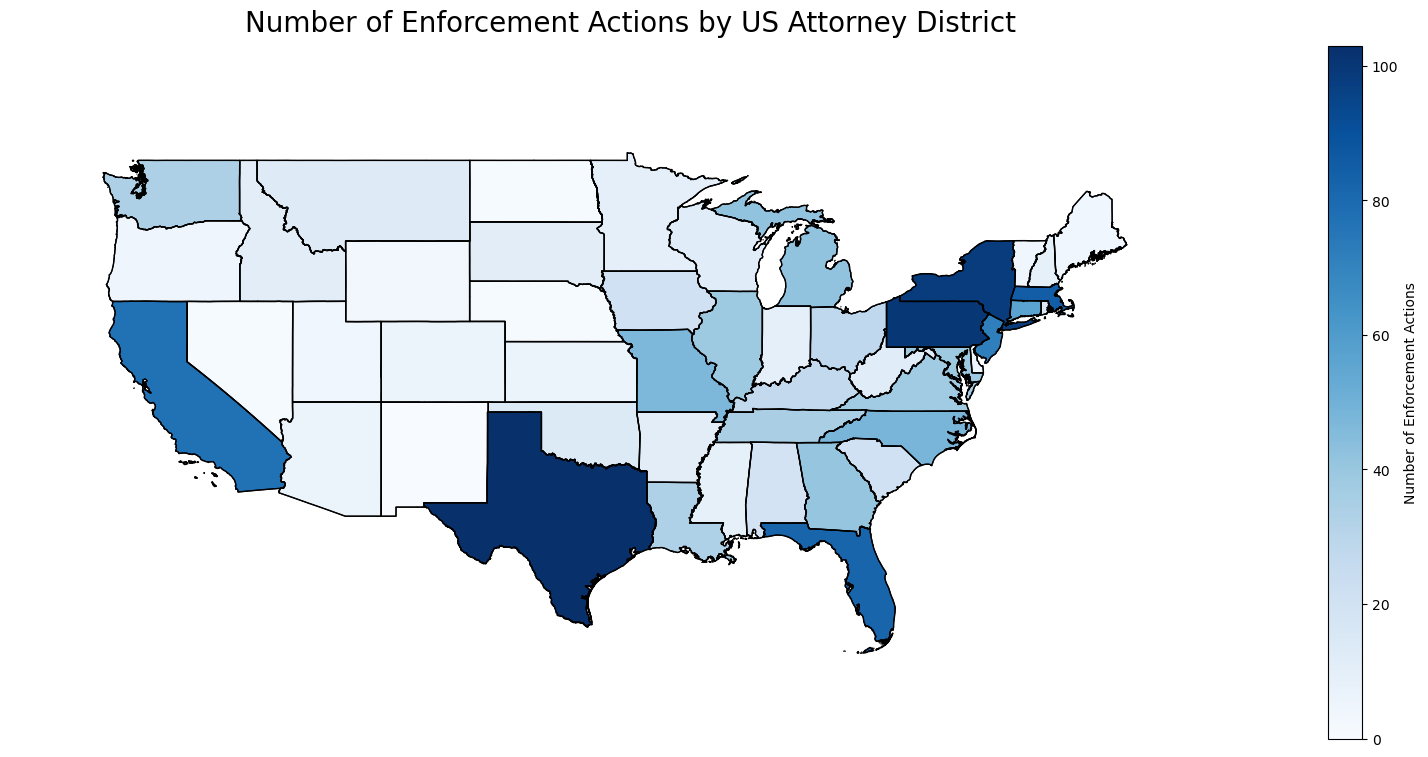

In [ ]:
file_path = "enforcement_actions_2021_1.csv"
data = pd.read_csv(file_path)

data["District"] = data["Agency"].apply(
    lambda x: (
        re.search(r"District of [A-Za-z ]+", x).group(0)
        if pd.notnull(x) and "District" in x
        else None
    )
)

district_data = data.dropna(subset=["District"]).copy()

district_data["District"] = (
    district_data["District"]
    .str.replace("U\.S\. Attorney's Office, ", "")
    .str.replace("District of ", "")
    .str.strip()
)

district_counts = district_data["District"].value_counts().reset_index()
district_counts.columns = ["District", "Count"]

shapefile_path = "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
gdf_districts = gpd.read_file(shapefile_path)

gdf_districts["District"] = gdf_districts["NAME"].str.strip()


gdf_merged = gdf_districts.merge(
    district_counts, how="left", left_on="District", right_on="District"
)
gdf_merged["Count"] = gdf_merged["Count"].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
gdf_merged.plot(
    column="Count",
    cmap="Blues",
    linewidth=0.8,
    ax=ax,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Number of Enforcement Actions", "shrink": 0.6},
)

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)
plt.title("Number of Enforcement Actions by US Attorney District", fontsize=20)
plt.axis("off")
plt.show()

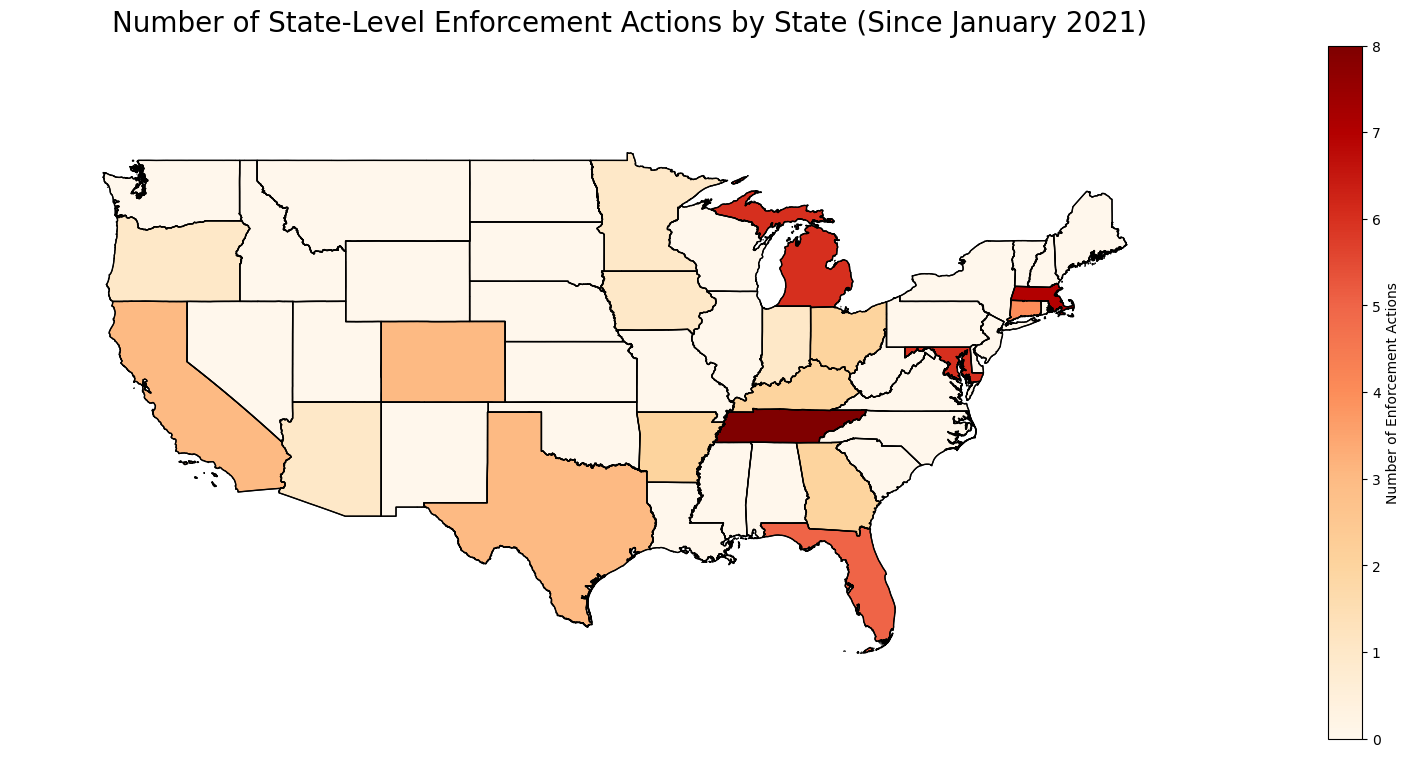

In [ ]:
import matplotlib.pyplot as plt

state_data = data[data['Agency'].str.contains(
    'State of', na=False, case=False)]


def extract_state_name(agency):
    parts = agency.split()
    if "State" in parts and "of" in parts:
        index = parts.index("of") + 1
        if index < len(parts):
            return parts[index]
    return None


state_data['State'] = state_data['Agency'].apply(extract_state_name)

state_data = state_data.dropna(subset=['State'])

state_data['State'] = state_data['State'].str.strip().str.title()

state_counts = state_data['State'].value_counts().reset_index()
state_counts.columns = ['State', 'Count']

gdf_states = gpd.read_file(
    "/Users/hahei/Desktop/problem-set-5-xy-wz/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")

gdf_states['NAME'] = gdf_states['NAME'].str.strip().str.title()

gdf_merged = gdf_states.merge(
    state_counts, how='left', left_on='NAME', right_on='State')
gdf_merged['Count'] = gdf_merged['Count'].fillna(0)

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

gdf_merged.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
gdf_merged.plot(column='Count', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='black', legend=True,
                legend_kwds={'label': "Number of Enforcement Actions",
                             'shrink': 0.6,
                             })

ax.set_xlim(-130, -60)
ax.set_ylim(20, 55)

plt.title('Number of State-Level Enforcement Actions by State (Since January 2021)', fontsize=20)
plt.axis('off')

plt.show()